In [2]:
# %% set up
# set path
import os
path1 = 'C:\\Users\\BSE\\Documents\\MaxVonMylius\\GeographyGrowth\\TermPaper\\py'
path2 = 'C:\\Users\\mmyli\\Documents\\HumboldtUni\\GeographyGrowth\\Paper\\shadow_projection_2D'
path = path1 if os.path.isdir(path1) else path2
os.chdir(path)

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.affinity import translate, scale
from shapely.ops import cascaded_union
from pysolar import solar
from datetime import datetime
import math
import pytz

# Define helper functions

### Learnings:
#### Speeding up code:
- accessing coords like poly.exterior.coords is very costly 

In [3]:
def createPolygon (n_edges:int, interiors:list=[], scale:int=1, shift:tuple=(0,0), convex:bool=True, regular:bool=True) -> Polygon:
    """
    creates and returns a Polygon based on the parameters given
    Polygon coordinates are points from the unit circle
    if regular == True, then all edges have same length, and all angle are equal 

    """
    if n_edges<3:
        raise ValueError('n_edges edeges must be at least 3 to create a polygon. n_edges was '+ str(n_edges))
    
    splitAt = np.random.randint(n_edges+1)
    scaleNonConvex = [1 for n in range(n_edges)] if convex else [(np.random.random()*2+0.5)/2.5 for n in range(n_edges)]
    rndm = [np.random.random()+0.1 for n in range(n_edges)]
    scaleNonReguar = [n/n_edges for n in range(n_edges)] if regular else [sum(rndm[:n])/sum(rndm) for n in range(n_edges)]
    # print(scaleNonReguar)
    coords = [(\
        shift[0]+scaleNonConvex[i]*scale*math.sin(scaleNonReguar[i] * 360 * math.pi / 180 ),\
        shift[1]+scaleNonConvex[i]*scale*math.cos(scaleNonReguar[i] * 360 * math.pi / 180 ) \
        ) for i in range(n_edges)]
    coords = coords[:splitAt] + coords[splitAt:]

    return Polygon(coords, interiors)    

In [4]:
def createConvexPolygon (n_edges:int, interiors:list=[], scale:int=1, shift:tuple=(0,0), regular:bool=True) -> Polygon:
    """
    creates and returns a Polygon based on the parameters given
    Polygon coordinates are points from the unit circle
    if regular == True, then all edges have same length, and all angle are equal 

    """
    return createPolygon(n_edges=n_edges, interiors=interiors, scale=scale, shift=shift, convex=True, regular=regular)
    

In [238]:
def createPolygonWithInteriors(n_edges:int=3, n_interiors:int=0, n_edges_interiors:int=3, regular:bool=True, convex:bool=True, convexInteriors:bool=True, max_iterations:int=10) -> Polygon:
    if regular:
        return createPolygon(n_edges, \
            interiors=[[\
            createPolygon(n_edges=n_edges_interiors, scale=1/(n*5), shift=(1/(n+2)*(i+1)-0.5*n/(n+1),0), \
                regular=regular, convex=convexInteriors).exterior for i in list(range(n))] for n in [n_interiors]][0],\
            convex=convex)
    
    # randomly create wholes within shape
    interiors = []
    interiorCenterCoords = []
    interiorScale = 1/(.25+math.log(n_interiors+3))
    interiorScales = [interiorScale]

    r = np.random.random()
    n_edges_irregular = int(2*(n_edges-3)*r+3)
    poly = createPolygon(n_edges_irregular, regular=regular, convex=convex)
    extCoords = poly.exterior.coords
    maxmax=2**n_interiors * 1000
    m=0
    for j in range(n_interiors):
        iteration = 0
        while len(interiors)-1 < j:
            # try different points in this
            if iteration == 0:
                boundingPoly = Polygon( [( (1-interiorScale)*coord[0], (1-interiorScale)*coord[1] ) for coord in extCoords] )
                interiorBounds = [ Polygon([ ( (1+interiorScale)*interiorScales[i]*(coord[0] - interiorCenterCoords[i][0]) + interiorCenterCoords[i][0], \
                    (1+interiorScale)*interiorScales[i]*(coord[1] - interiorCenterCoords[i][1]) + interiorCenterCoords[i][1] ) \
                    for coord in interiors[i]]) for i in range(len(interiors))]
                # bounds = (minx, miny, maxx, maxy)
                bounds = boundingPoly.bounds
            #
            
            # find random point within Polygon (but at some distance of edges)
            p = Point(bounds[0]-1, bounds[1]-1)
            
            while not (boundingPoly.contains(p) and not any([ib.contains(p) for ib in interiorBounds])):
                p = Point((bounds[2]-bounds[0])*np.random.random()+bounds[0], (bounds[3]-bounds[1])*np.random.random()+bounds[1])
                
                m+=1
                if maxmax == m:
                    print("bounds",bounds)
                    print("boundingPoly",list(boundingPoly.exterior.coords))
                    print("p.coords", p.coords[0])
                    print("boundingPoly.contains(p)",boundingPoly.contains(p))
                    print("interiorBounds",interiorBounds)
                    print("m",m)
                    gpd.GeoSeries([poly, boundingPoly] + interiorBounds).plot(cmap="viridis", alpha=0.4, edgecolor="black")
                    return
            
            r = np.random.random()
            n_edges_interiors_irregular = int(2*(n_edges_interiors-3)*r+3)
            interior = createPolygon(n_edges=n_edges_interiors_irregular, scale=interiorScale, shift=list(p.coords)[0], regular=regular, convex=convexInteriors).exterior
            
            if poly.contains(interior):
                interiors.append(list(interior.coords))
                poly = Polygon(extCoords, [x for x in interiors])
                interiorScales.append(interiorScale)
                interiorCenterCoords.append(p.coords[0])
                iteration = 0
            else:
                if iteration == max_iterations - 1:
                    interiorScale *= 0.9*(1-m/maxmax)**2 
                iteration = (iteration+1) % max_iterations
        #
    #
    return poly


In [6]:
def clockWiseAngle (refVec,vec) -> float:
    """
    input refVec and vec are vectors of length 2
    return the angle relative to refVec in clockwise direcetion
    from 0 to 360 degrees
    """
    rad = math.atan2(refVec[0], refVec[1]) - math.atan2(vec[0], vec[1])
    return ( rad if rad > 0 else rad + 2*math.pi)*180/math.pi % 360

In [7]:
def vectorize (startPoint:tuple=(0,0), endPoint:tuple=(0,0)) -> tuple:
    """
    return vector from startPoint to endPoint
    """
    return tuple([endPoint[i]-startPoint[i] for i in range(len(startPoint))])

In [8]:
def noDoubleCoords (coords):
    """
    Function that clean coordinates such a coordinate that directly follows itself is removed
    """
    return [coords[i] for i in range(len(coords)) if not coords[i] == coords[(i+1)%len(coords)]]

In [664]:
def mostTowardsVector (coords:list, vector:tuple):
    """
    check which point lies most into th direction of a vector
    2do it works but i have to work on the idea itself.
    not the point that is most in the direction is not included
    """
    # vector from A=(x1,y1)  to B=(x2,y2) P=(x,y)
    # print("coords",coords)
    # print("vector",vector)
    # (x−x1)(y2−y1)−(y−y1)(x2−x1)
    vals = [(coords[i][0])*(vector[0]-0)-(coords[i][1])*(-vector[1]-0) for i in range(len(coords))]
    # print(vals)
    index = vals.index(max(vals))
    
    return index

In [663]:
def projectTriangleShadow (coords:shapely.coords.CoordinateSequence or list, vector:tuple)->list:
    """
    Inputs:
    coords = list of tuples of which the first three are taken into account
    vector = tuple indicating a vector from origion (0,0) to point(vector)
    Idea: 
    A triangle that is projected a long a vector of positive length is alwas transformed into a pentagon
    which consits of all points of orignal triangle and points of triangle shifted with vector 
    excluding one point (the one not left or rightmost in angle direction) from origanal triangle
    if that point is most fast towards vector direction out of the three points of that orig triangle
    else exclude that point from the shifted triangle
    """
    
    if(not len(coords) == 3 and not len(set(coords))==3):
        coords = list(set(coords))
        if(not len(coords)==3):
            raise ValueError("coords provided to triangle projectTriangleShadow are not of length 3:",len(coords))

    # check how far the coordinates are left or right of base vector 
    offsetOrthogonal = [(coords[i][0])*(vector[1])-(coords[i][1])*(vector[0]) for i in range(3)]
    minI = offsetOrthogonal.index(min(offsetOrthogonal))
    maxI = offsetOrthogonal.index(max(offsetOrthogonal))
    midI = 3 - maxI - minI
    
    # check if mid coordinate is most towards vector direction
    offsetTowardsVector = [(coords[i][0])*(vector[0])+(coords[i][1])*(vector[1]) for i in range(3)]

    # add those coordinates that are left and right most of original and shifted triangle 
    shadowCoords = [\
        (coords[minI][0],coords[minI][1]),\
        (coords[minI][0]+vector[0],coords[minI][1]+vector[1]),\
        (coords[maxI][0]+vector[0],coords[maxI][1]+vector[1]),\
        (coords[maxI][0],coords[maxI][1]),\
        ]
    
    # include mid coord from orig triangle if no point is less into vector direction  
    if offsetTowardsVector[midI] == min(offsetTowardsVector):
        shadowCoords.append((coords[midI][0], coords[midI][1]))
    else:
        shadowCoords.insert(2, (coords[midI][0]+vector[0], coords[midI][1]+vector[1]))

    return Polygon(shadowCoords)




In [9]:
def definedClockwise (coords):
    """
    return whether coords are defined clockwise
    """
    
    return sum([(coords[(i+1)%len(coords)][0]-coords[i][0])*(coords[(i+1)%len(coords)][1]+coords[i][1]) for i in range(len(coords))])>0

In [10]:
def splitPolygonToPolygonsWithoutInteriors (poly:Polygon, plot=False) -> list:
    """
    convert any polygon to array of polygons that do not cotaining any interiors
    
    For conistencies all coord rings are made clockwise

    Assumption: 
    for each polygon with interiors there exist an interior with points j and j0 for j != j0
    that you can connect with a valid line from to j the exterior point k and from j0 to k0 for k != k0
    """
    interiors = poly.interiors
    # early return if no interiors
    if len(interiors) == 0:
        return [poly]
    
    extCoords = noDoubleCoords(poly.exterior.coords)
    # extCoords = poly.exterior.coords
    # extCoords = [extCoords[i] for i in range(len(extCoords)) if not extCoords[i] == extCoords[(i+1)%len(extCoords)]]

    # clean coordinates
    interiorsCoords = [noDoubleCoords(interior.coords) for interior in interiors]
    # interiorsCoords = \
    #     [[coords[i] for i in range(len(coords)) if not coords[i] == coords[(i+1)%len(coords)]] \
    #     for coords in [interior.coords for interior in interiors]]
    
    # print("clockwise ext", definedClockwise(extCoords), "interiors", \
    #     [definedClockwise(interiors[i].coords) for i in range(len(interiors))])
    
    # if sum([(extCoords[i+1][0]-extCoords[i][0])*(extCoords[i+1][1]+extCoords[i][1]) for i in range(len(extCoords)-1)])>0:
    if definedClockwise(extCoords):
        extCoords.reverse()
    # print("extCoords",extCoords)
    

                        
    i = 0
    while i < len(interiors):
        # interiorIsClockwise = sum([(interiorsCoords[i][n+1][0]-interiorsCoords[i][n][0])*(interiorsCoords[i][n+1][1]+interiorsCoords[i][n][1]) for n in range(len(interiorsCoords[i])-1)])>0
        # if not interiorIsClockwise:
        if not definedClockwise(interiorsCoords[i]):
            interiorsCoords[i].reverse()
        # store here the indices j0/j at which interior shall be split and k0/k to split exterior
        j0, k0 = -1, -1
        j=0
        # stop trying for interior i as soon as you can't connect two seperate coordinates to exterior 
        while j < len(interiorsCoords[i]) - (k0 == -1):
            k = 0
            while k < len(extCoords) and not j == j0:
                k1 = k if k0==-1 else (len(extCoords)//2+k+k0) % len(extCoords)
                if k1 != k0 and poly.contains(LineString([interiorsCoords[i][j], extCoords[k1]])) and \
                    not (k1 != -1 and LineString([interiorsCoords[i][j], extCoords[k1]]).intersects(LineString([interiorsCoords[i][j0], extCoords[k0]]))):
                    #fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (1,1))
                    # gpd.GeoSeries([poly]).plot(ax=axs)
                    # gpd.GeoSeries([LineString([interiorsCoords[i][j], extCoords[k1]])]).plot(ax=axs, color = "red")
                    if k0 == -1:
                        j0, k0 = j, k1
                        # k1 index such that it will start with 0 at next iteration
                        k = 0
                        continue
                    else:
                        # print("interiorsCoords",interiorsCoords[i])
                        # print("connect k1 ", k1, extCoords[k1], "to j ", j, interiorsCoords[i][j])
                        # print("connect k0 ", k0, extCoords[k0], "to j0 ", j0, interiorsCoords[i][j0])
                        # as k1 could be smaller than k0 split at min(k0,k1) and max(k0,k1) 
                        splittedExterior = [ extCoords[min(k0,k1):max(k0,k1)+1], extCoords[max(k0,k1):] + extCoords[:min(k0,k1)+1] ]
                        splittedInterior = [ interiorsCoords[i][j0:j+1], interiorsCoords[i][j:] + interiorsCoords[i][:j0+1] ]
                        # print("splittedExterior", splittedExterior)
                        # print("splittedInterior",splittedInterior)
                        # # vector from interior i at split point j to exterior at split point k1
                        # v0 = (extCoords[k1][0]-interiorsCoords[i][j][0], extCoords[k1][1]-interiorsCoords[i][j][1])
                        # # vector from exterior point k1 to k1-1
                        # v1 = (extCoords[(k1-1)%len(extCoords)][0]-extCoords[k1][0], extCoords[(k1-1)%len(extCoords)][1]-extCoords[k1][1])
                        # # vector from exterior point k1 to k1+1
                        # v2 = (extCoords[(k1+1)%len(extCoords)][0]-extCoords[k1][0], extCoords[(k1+1)%len(extCoords)][1]-extCoords[k1][1])
                        # # vector from exterior point j to j-1
                        # v3 = (extCoords[(j-1)%len(extCoords)][0]-extCoords[j][0], extCoords[(j-1)%len(extCoords)][1]-extCoords[j][1])
                        # # vector from exterior point j to j+1
                        # v4 = (extCoords[(j+1)%len(extCoords)][0]-extCoords[j][0], extCoords[(j+1)%len(extCoords)][1]-extCoords[j][1])
                        
                        # print("splittedExterior not reversed", splittedExterior)
                        #2d0 it is not clear when to comment out next line...
                        [arr.reverse() for arr in splittedExterior]
                        # print("splittedExterior reveresed", splittedExterior)
                        
                        # print("splittedExterior[0]", splittedExterior[0])
                        # print("splittedInterior[0]",splittedInterior[0])
                        # print("splittedExterior[1]", splittedExterior[1])
                        # print("splittedInterior[1-0]",splittedInterior[1])

                        # check within a LineString(extCoordsA[x], intCoordsA[y]).crosses(interior)
                        # no because this can also happen in the other case
                        polyCoords = [splittedExterior[0] + splittedInterior[0], \
                            splittedExterior[1] + splittedInterior[1] ]
                        polygons = [Polygon(coords) for coords in polyCoords]
                        if(plot):
                            fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                            gpd.GeoSeries(polygons).plot(ax=axs, alpha=0.4, cmap="viridis", edgecolor="black")
                            gpd.GeoSeries([Point((2.5, 1.5)), LineString([interiorsCoords[i][j], extCoords[k1]]), LineString([interiorsCoords[i][j0], extCoords[k0]])]).plot(ax=axs, edgecolor="red")
                            fig.show()
                        
                        # early return if just one interior
                        if len(interiors) == 1:
                            return polygons
                        
                        #else check where to nest further
                        polygons = [Polygon(coords,[interiors[n] for n in range(len(interiors)) if not n == i and Polygon(coords).contains(interiors[n])]) for coords in polyCoords]
                        polygons = [item for sublist in [[ply] if len(ply.interiors) == 0 else splitPolygonToPolygonsWithoutInteriors(ply,plot=plot) for ply in polygons] for item in sublist]
                        return polygons
                k += 1
            j += 1
        i += 1
    #

In [11]:
def splitPolygonToPolygonsWithoutInteriors (poly:Polygon, plot=True) -> list:
    """
    convert any polygon to array of polygons that do not cotaining any interiors
    
    For conistencies all coord rings are made clockwise

    Assumption: 
    for each polygon with interiors there exist an interior with points j and j0 for j != j0
    that you can connect with a valid line from to j the exterior point k and from j0 to k0 for k != k0
    """
    interiors = poly.interiors
    # early return if no interiors
    if len(interiors) == 0:
        return [poly]
    
    polyExterior = poly.exterior
    extCoords = noDoubleCoords(polyExterior.coords)
    interiorsCoords = [noDoubleCoords(interior.coords) for interior in interiors]
    
    if not definedClockwise(extCoords):
        extCoords.reverse()
                        
    i = 0
    while i < len(interiors):
        interiorWasClockwise = definedClockwise(interiorsCoords[i])
        if interiorWasClockwise:
            interiorsCoords[i].reverse()
        # store here the indices j0/j at which interior shall be split and k0/k to split exterior
        j, j0, k0, line0 = 0, -1, -1, -1
        
        # stop trying for interior i as soon as you can't connect two seperate coordinates to exterior 
        while j < len(interiorsCoords[i]) - (k0 == -1):
            k = 0
            while k < len(extCoords) and not j == j0:
                
                line = LineString([interiorsCoords[i][j], extCoords[k]])
                
                # perform multiple checks whether line from interior to exterior shall be chosen
                # line.intersects(edge) and not line.touches(edge) handles case where line partly overlays with edge but doesn't cross
                if \
                    k != k0 \
                    and poly.contains(line) \
                    and not (k0 != -1 and (line.intersects(line0) or line.touches(line0)) )\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([interiorsCoords[i][n], interiorsCoords[i][(n+1)%len(interiorsCoords[i])]]) for n in range(len(interiorsCoords[i]))]])\
                    and not any([line.intersects(edge) and not line.touches(edge) for edge in [LineString([extCoords[n], extCoords[n+1]]) for n in range(len(extCoords)-1)]]):
                    
                    if k0 == -1:
                        j0, k0, line0 = j, k, line
                        # reset k index such that it will start with 0 in next iteration
                        k = 0
                        continue
                    
                    else:
                        # divide polygon into two parts A and B
                        intA = interiorsCoords[i][j0:j+1]
                        intB = interiorsCoords[i][j:] + interiorsCoords[i][:j0+1]
                        extA = (extCoords[k:] + extCoords[:k0+1]) if k0<k else extCoords[k:k0+1]
                        extB = (extCoords[k0:] + extCoords[:k+1]) if k0>k else extCoords[k0:k+1]

                        polyCoords = [extA + intA, extB + intB ]
                        polygons = [Polygon(coords) for coords in polyCoords]
                        
                        if(plot):
                            fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
                            gpd.GeoSeries(polygons).plot(ax=axs, alpha=0.4, cmap="viridis", edgecolor="black")
                            gpd.GeoSeries([Point(interiorsCoords[i][j]), Point(interiorsCoords[i][j0]) ]).plot(ax=axs, cmap="tab10", linewidth=3)
                            gpd.GeoSeries([Point(extCoords[k]), Point(extCoords[k0]) ]).plot(ax=axs, cmap="tab10", linewidth=3)
                            gpd.GeoSeries([line, line0]).plot(ax=axs, cmap="tab10", linewidth=3)
                            for x, y, label in zip([extCoords[x][0] for x in range(len(extCoords))], [extCoords[x][1] for x in range(len(extCoords))], [str(x) for x in range(len(extCoords))]):
                                axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                            for x, y, label in zip([interiorsCoords[i][x][0] for x in range(len(interiorsCoords[i]))], [interiorsCoords[i][x][1] for x in range(len(interiorsCoords[i]))], [str(x) for x in range(len(interiorsCoords[i]))]):
                                axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
                        
                        # early return if just one interior
                        if len(interiors) == 1:
                            return polygons
                        
                        #else check where to nest further
                        polygons = [Polygon(coords,[interiors[n] for n in range(len(interiors)) if not n == i and Polygon(coords).contains(interiors[n])]) for coords in polyCoords]
                        polygons = [item for sublist in [[ply] if len(ply.interiors) == 0 else splitPolygonToPolygonsWithoutInteriors(ply,plot=plot) for ply in polygons] for item in sublist]
                        return polygons
                k += 1
            j += 1
        i += 1
    #

In [12]:
def tryConnections (bC:tuple, coords:list, coordRings:list, coordsInteriors:list, poly:Polygon):
        """
        bC is the problematic coord that is connected multiple times
        coord1 is one coord ring
        coord2 can be coords from multiple rings
        Connecting LineString has be contained within Polygon
        """
        
        connecIndices = None
        # sort coord rings that you first try those coord rings that contain bC, because this immediatly splits polygon
        # others should be 
        # 2do in general think whether there is an algorithm to split polys containing interiors into multiple polygons not containg interiors
        coordRingsSorted = [x[1] for x in sorted(enumerate(coordRings), key=lambda i,cr: (bC not in cr,i))]
        k = 0
        while i<len(coordRingsSorted):
            i=0
            while i<len(coords):
                if not coords[i] == bC:
                    j=i+1
                    while j<len(coordRingsSorted[k]):
                        if not coordRingsSorted[k][j] == bC:
                            if poly.contains(LineString([coords[i], coordRingsSorted[k][j]])):
                                connecIndices = [i,j,k]
                            if connecIndices:
                                break
                            j+=1
                    if connecIndices:
                            break
                i+=1
            if connecIndices:
                break
            k+=1
        #
        return connecIndices
#

In [13]:
def splitToValidCoordinateRings (arr) -> list:
    """
    inputs:
    arr: list of coordinate [(0,0),(1,1),...]
    Function splits list of potentially invalid coordinate rings into array valid coordinate rings 
    Such that each coordinate ring does never intersect the same coordinate twice 
    E.g. a shape like the number 8 does drawn as a line would be split into two rings (upper and lower o-shape)
    Further the functions simplifies [x,y,y,z,x] to [x,y,z]
    ### 2d0 the logic is bad! rethink that it should divide instead of splitting coord rings
    
    """
    # print("arr0", arr)
    arr = [arr[i] for i in range(len(arr)) if not arr[i] == arr[(i+1)%len(arr)]]
    # print("initail",arr)
    if len(arr)==len(set(arr)):
        # print("early return", arr)
        return [arr]
    maxEl = max(set(arr), key=arr.count)
    arr = arr[(arr.index(maxEl)+1)%len(arr):] + arr[:(arr.index(maxEl)+1)%len(arr)]
    # print("not early return",arr)
    splitIndices = [0]+[i for i, x in enumerate(arr) if x == maxEl]
    # print("splitIndices",splitIndices)
    # res = [[item for sublist in \
    #     splitToValidCoordinateRings(arr[splitIndices[i]:splitIndices[i+1]+1])\
    #     for item in sublist]\
    #     for i in range(len(splitIndices)-1)]
    validDivison = False
    i=0
    while not validDivison:
        splitIndices[i]+1
    print("res0", arr)
    res = [
        arr[splitIndices[i]:splitIndices[i+1]+1]\
        for i in range(len(splitIndices)-1)] 
    print("res1", res)
    
    res = [[a[i] for i in range(len(a)) if not a[i] == a[(i+1)%len(a)]] \
        for a in \
        res]
    # here make the split
        
    [arr for arr in res]

    print("res2",res)
    res = [b if len(b)==len(set(b)) else splitToValidCoordinateRings(b) \
        for b in \
        res]
    print("res3",res)

    # res = [b if len(b)==len(set(b)) else splitToValidCoordinateRings(b) \
    #     for b in \
    #     [[item for sublist in \
    #     arr[splitIndices[i]:splitIndices[i+1]+1]\
    #     for item in sublist]\
    #     for i in range(len(splitIndices)-1)]]

    print("res",res)
    return res

In [14]:
def addSelfIntersectingCoords(coords) -> list:
    """
    inputs:
    coords = list of coordinates
    """
    edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
    # 2do check that sorted sorts in correct order
    coordsWithIntersectionPoints = \
        [item for sublist in [[coords[i]]+\
        [item for sublist in \
        [sorted(list(edges[i].intersection(edges[j]).coords),\
        key=lambda intersec: abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
        for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
        for item in sublist] \
        for i in range(len(coords)-1)] \
        for item in sublist]
    # print("coordsWithIntersectionPoints",coordsWithIntersectionPoints)
    return coordsWithIntersectionPoints

In [15]:
# maybe vectorAngle is not necessary as cut outs will be added as interiors
def vectorAngle (a, b) -> float:
    return math.acos((sum([a[i]*b[i] for i in range(len(a))])) / (math.sqrt(sum([x**2 for x in a])) * math.sqrt(sum([x**2 for x in b]))))*180/math.pi
    # return math.acos((a[0]*b[0] + a[1]*b[1] ) / (math.sqrt(a[0]**2 + a[1]**2) * math.sqrt(b[0]**2 + b[1]**2)))

In [16]:
def makePolygonValid (poly:Polygon) -> list:
    """
    return polygon as list of valid polygons
    """
    [x for x in ]
    Polygon()

    if type(poly.boundary)==LineString or not poly.is_valid:
        # split polygon into valid parts
        coords = poly.boundary.coords # 2do maybe the intersections are not visible from points
        print("poly.boundary.coords", list(poly.boundary.coords))
        triangleList = \
            [\
                [item for sublist in \
                    triangularize(Polygon(\
                        coordRing, \
                        [[item for sublist in splitToValidCoordinateRings(addSelfIntersectingCoords(list(interior.coords))) for item in sublist] \
                        for interior in poly.interiors if Polygon(coordRing).contains(interior)]\
                    )) \
                for item in sublist]\
            for coordRing in splitToValidCoordinateRings(addSelfIntersectingCoords(coords))]
        print("after invalid shape:",triangleList)
        # return triangleList
        
    return []

SyntaxError: invalid syntax (1953581457.py, line 5)

In [ ]:
def triangularize(poly:Polygon, lvl:int=0, maxIteration:int=300, plot:bool=True) -> list:
    """
    2Do add description for fctn...
    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    poly0 is the original polygon geometry passed in. When the triangularize fct is nested the original polygon shall be passed as an argument here.
    lvl indicates the deepness of the nest
    """
    # handles cases where polygon has holes
    if lvl == 0 and len(poly.interiors)>0:
        #2do validate polygon at this step
        triangleList =  \
            [item for sublist in \
                [triangularize(polyWithoutInteriors) for polyWithoutInteriors in splitPolygonToPolygonsWithoutInteriors(poly, plot)]\
            for item in sublist]
        return triangleList
    # thus from here on polygon does not have any holes by definition
    coords = noDoubleCoords(poly.exterior.coords)
    
    # early return if shape is regular triangle
    if(len(coords)<4):
        return [poly]

    
    
    if(lvl>maxIteration): #2do remove after testing
        print(lvl, "to many")
        return
    
    #2do create seperate polygon validation function
    # if type(poly.boundary)==LineString or not poly.is_valid:
    #     # split polygon into valid parts
    #     print("poly.boundary.coords", list(poly.boundary.coords))
    #     triangleList = \
    #         [\
    #             [item for sublist in \
    #                 triangularize(Polygon(coordRing)) \
    #             for item in sublist]\
    #         for coordRing in splitToValidCoordinateRings(addSelfIntersectingCoords(coords))]
    #     print("after invalid shape:",triangleList)
    #     return triangleList
    
    base = coords[0]
    
    # obtain list of line indexes that do not cross polygon
    #   think about how line indexes correspond to coordindexes:
    #   len(lines_including_non_valid) = len(coords) - 3
    #   thus:
    #   lI=0 <=> cI = 2
    #   lI=1 <=> cI = 3
    #   lI=2 <=> cI = 4
    #   ...
    #   lI=-2 <=> cI = -3
    #   lI=-1 <=> cI = -2
    #   Because of perfect correspondence we just need to safe the line indexes 

    #   coord at index cI removed from extCoords if:
    #       lines include lI = cI-3, cI-2, cI-1
    #       if cI-3<0 it counts as included (first coordinate)
    #       if cI-2>=len(lines_including_non_valid) it counts as included (last coordinate)
    #   if the coord can be removed check if precessed by baseCoord. if not replace it with baseCoord. 
    lineIndexes = \
        [i for i in range(0,len(coords)) if i==0 or i==1 or i==len(coords)-1 or poly.contains(LineString([base, coords[i]]))]
    
    triangleList = [Polygon([base, coords[i], coords[(i+1)%len(coords)]]) \
        for i in lineIndexes if i+1 in lineIndexes and not i+1<len(coords) ]
    
    # obtain list of coordinates for exterior that remain after having removed all triangles
    # 2do: there might be a mistake here. especially check [base] logic.
    print("len(triangleList)",len(triangleList))
    if(len(triangleList)==0):
        coordRings = [noDoubleCoords(coords[:lineIndexes[2]+1]), noDoubleCoords([base]+coords[lineIndexes[2]:])]
    else:
        # extCoordsMod = [item for sublist in\
        #     [\
        #     [item for sublist in\
        #     [([coords[i]] if not (i in lineIndexes and (i-1 in lineIndexes or i<=1) and (i+1 in lineIndexes or i+1==len(coords))) else [])\
        #     + ([base] if i in lineIndexes and (i+1 in lineIndexes or i+1==len(coords)) else [])] \
        #     for item in sublist]\
        #     for i in range(len(coords))]\
        #     for item in sublist]

        extCoordsMod = [coords[i] if not (i in lineIndexes \
            and (i-1 in lineIndexes or i-1==0) and (i+1 in lineIndexes or i+1 > len(coords)) ) \
            else base for i in range(len(coords))]

        # print("extCoordsMod",extCoordsMod)
        
        # remove duplicated coords
        extCoordsMod = noDoubleCoords(extCoordsMod)
        
        # print("extCoordsMod",extCoordsMod)
        # splitIndex = (len(extCoordsMod)//2 + (1 if (len(extCoordsMod)+2)%4 == 0 else 0)) %len(extCoordsMod)+(len(extCoordsMod)+1)%2
        
        # splitIndex = 1
        # extCoordsMod = extCoordsMod[splitIndex:]+extCoordsMod[:splitIndex]
        if len(extCoordsMod) == len(set(extCoordsMod)):
            coordRings = splitToValidCoordinateRings(extCoordsMod)
        else:
            coordRings = [extCoordsMod]
    
    print("coordRings",[len(x) for x in coordRings])
    # add and create triangles if the line to a point and the line to a previous point are both valid
    # Handle first triangle(base, coords[1], coords[2]) by returning true if i==0
    # Handle last triangle case for first triangle(base, coords[-1], coords[-2])
    # triangleList = [Polygon([base, coords[i+1], coords[i+2]]) \
    #     for i in lineIndexes if (i-1 in lineIndexes or i==0 or i>len(coords)-3)]
    
    # print(len(triangleList))
    for coordRing in coordRings:
        if len(set(coordRing)) >2:
            print("coordring")
            splitAt = (len(coordRing)//2 + (1 if (len(coordRing)+2)%4 == 0 else 0)) %len(coordRing)+(len(coordRing)+1)%2
            coordRing = coordRing[splitAt:]+coordRing[:splitAt]
            triangleList += triangularize(poly=Polygon(coordRing), lvl=lvl+1,maxIteration=maxIteration, plot=plot)
    
    if(plot and lvl==0):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
        # gpd.GeoSeries([poly]).plot(ax=axs, color = "grey", edgecolor="pink")
        gpd.GeoSeries(triangleList).plot(ax=axs, cmap = "viridis", edgecolor="grey")
        gpd.GeoSeries([LineString([base, coords[i]]) for i in range(1,len(coords)) if i>1 and i<len(coords)-1 and poly.contains(LineString([base, coords[i]]))]).plot(ax=axs, color = "red")
        gpd.GeoSeries([Point(base)]).plot(ax=axs, color = "red")
    
    return triangleList
    #
#

In [221]:
# try an even simpler version:
# just divide polygon as 
def triangularize(poly:Polygon, lvl:int=0, maxIteration:int=300, plot:bool=True) -> list:
    """
    2Do add description for fctn...
    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    poly0 is the original polygon geometry passed in. When the triangularize fct is nested the original polygon shall be passed as an argument here.
    lvl indicates the deepness of the nest
    """
    # handles cases where polygon has holes
    if lvl == 0 and len(poly.interiors)>0:
        #2do validate polygon at this step
        triangleList =  \
            [item for sublist in \
                [triangularize(polyWithoutInteriors) for polyWithoutInteriors in splitPolygonToPolygonsWithoutInteriors(poly, plot)]\
            for item in sublist]
        return triangleList
    # thus from here on polygon does not have any holes by definition
    coords = noDoubleCoords(poly.exterior.coords)
    # print("lvl",lvl, "len(coords)",len(coords), len(set(coords)))
    
    # early return if shape is regular triangle
    if(len(set(coords))<4):
        print("early return", [poly])
        return [poly]

    line = LineString([coords[0],coords[2]])
    i,j = 0,2
    while i < len(coords):
        line = LineString([coords[i],coords[j%len(coords)]])
        # print(i,j,"poly.contains",poly.contains(line))
        if(j < len(coords)):
            if poly.contains(line):
                coordRings = [coords[i:j+1], coords[i:i+1]+coords[j:]]
                coordRings = [coords[i:j+1], coords[:i+1]+coords[j:]]\
                    if i<j else \
                    [coords[j:i+1], coords[:j+1]+coords[i:]]
                # print("len CR", [len(x) for x in coordRings])
                # polygonList = [item for sublist in \
                #     [triangularize(poly=Polygon(coordRings[i]), lvl=lvl+1,maxIteration=maxIteration, plot=plot)\
                #     for i in range(2)] for item in sublist]
                
                polygonList = []
                for coordRing in coordRings:
                    if len(coordRing)>3:
                        res = triangularize(poly=Polygon(coordRing), lvl=lvl+1,maxIteration=maxIteration, plot=plot)
                    else:
                        res = [Polygon(coordRing)]
                    # print("res",res)
                    polygonList.extend(res)
                
                if(plot and lvl==0):
                    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
                    gpd.GeoSeries([poly]).plot(ax=axs, color = "white", edgecolor="black", linewidth=4)
                    gpd.GeoSeries(polygonList).plot(ax=axs, alpha=0.6, cmap = "viridis", edgecolor="black")
            
                return polygonList
            #
            j += 1
        else:
            # print("add +1 to i",i, "j at ",j, "max",len(coords)-1)
            i += 1
            j = i+2
        #
    #
    print("did not return anything...", i, j, coords)
    #
#

In [14]:
# next step remove duplicate coordinates [(0,0),(1,0),(0,0),(0,0),(0,0),(0,0)]
# make it sucessfull for holes
# deal correctly with leftovers after holes are done
# comment code
# 2do: write code for interiors more compact.

def triangularizeWithInteriors(poly:Polygon, poly0=None, lvl:int=0, plot:bool=True):
    """
    This function is not working yet. 
    After struggling with it the approach was changed to first divide any polygon with an interior to polygons without interiror 

    Inputs: 
    poly = Polygon that will be triangularized. That may Polygon may have any shape and may have multiple holes (=interiors)
    poly0 is the original polygon geometry passed in. When the triangularize fct is nested the original polygon shall be passed as an argument here.
    lvl indicates the deepness of the nest
    """
    if(poly0==None):
        poly0 = poly
    if(lvl>20): #2do make this large enough
        return []
    
    if type(poly.boundary)==LineString or not poly.is_valid:
        # split polygon into valid parts
        coords = poly.boundary.coords # 2do maybe the intersections are not visible from points
        print("poly.boundary.coords", list(poly.boundary.coords))
        triangleList = \
            [\
                [item for sublist in \
                    triangularize(Polygon(\
                        coordRing, \
                        [[item for sublist in splitToValidCoordinateRings(addSelfIntersectingCoords(list(interior.coords))) for item in sublist] \
                        for interior in poly.interiors if Polygon(coordRing).contains(interior)]\
                    )) \
                for item in sublist]\
            for coordRing in splitToValidCoordinateRings(addSelfIntersectingCoords(coords))]
        print("after invalid shape:",triangleList)
        return triangleList
    
    hasInteriors, bC = len(poly.interiors)>0, poly.boundary[0].coords[0]
    coords =\
        [poly.boundary[0].coords[i] for i in range(len(poly.boundary[0].coords)) \
        if not poly.boundary[0].coords[i] == poly.boundary[0].coords[(i+1)%len(poly.boundary[0].coords)]]
    
    # early return if shape is regular triangle
    if(not hasInteriors and len(coords)<4):
        return [poly]
    
    # obtain list of line indexes that do not cross polygon
    #   think about how line indexes correspond to coordindexes:
    #   len(lines_including_non_valid) = len(coords) - 3
    #   thus:
    #   lI=0 <=> cI = 2
    #   lI=1 <=> cI = 3
    #   lI=2 <=> cI = 4
    #   ...
    #   lI=-2 <=> cI = -3
    #   lI=-1 <=> cI = -2
    #   Because of perfect correspondence we just need to safe the line indexes 

    #   coord at index cI removed from extCoords if:
    #       lines include lI = cI-3, cI-2, cI-1
    #       if cI-3<0 it counts as included (first coordinate)
    #       if cI-2>=len(lines_including_non_valid) it counts as included (last coordinate)
    #   if the coord can be removed check if precessed by baseCoord. if not replace it with baseCoord. 
    lineIndexes = [line[0] for line in enumerate([LineString([bC, coords[i]]) \
        for i in range(2,len(coords)-1)]) if poly0.contains(line[1])]
        

    # obtain list of coordinates for exterior that remain after having removed all triangles
    # 2do: there might be a mistake here. especially check [bC] logic.
    
    extCoordsMod = [coords[i] if not ((i-3 in lineIndexes or i-3<0) \
        and (i-2 in lineIndexes or i-2<0) and(i-1 in lineIndexes or i-1 > len(coords)-3) ) \
        else bC for i in range(len(coords))]
    # remove duplicated coords
    extCoordsMod = [extCoordsMod[i] for i in range(len(extCoordsMod)) if not extCoordsMod[i] == extCoordsMod[(i+1)%len(extCoordsMod)]]

    # add and create triangles if the line to a point and the line to a previous point are both valid
    # Handle first triangle(bC, coords[1], coords[2]) by returning true if i==0
    # Handle last triangle case for first triangle(bC, coords[-1], coords[-2])
    triangleList = [Polygon([bC, coords[i+1], coords[i+2]]) \
        for i in lineIndexes if (i-1 in lineIndexes or i==0 or i==len(coords)-3)]
    
    if(plot):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (1,1))
        gpd.GeoSeries([poly]).plot(ax=axs, color = "grey", edgecolor="pink")
        gpd.GeoSeries(triangleList).plot(ax=axs, cmap = "Greens", edgecolor="red")
        gpd.GeoSeries([line[1] for line in enumerate([LineString([bC, coords[i]]) \
        for i in range(2, len(coords)-1)]) if poly0.contains(line[1])]).plot(ax=axs, color = "black")
        gpd.GeoSeries([Point(bC)]).plot(ax=axs, color = "black")
        
    # finalList =  []
    # for triangle in triangleList:
    #     j = 0
    #     triangleInteriors, cond = [], True
    #     while cond:
    #         if(triangle.contains(poly.interiors[j])):
    #             triangleInteriors.append(poly.interiors[j])
    #         else: 
    #             if(j>len(poly.interiors)-1):
    #                 cond = False
    #             else: 
    #                 j += 1
    #     if(len(triangleInteriors)>0):
    #         finalList.extend(triangularize(Polygon(triangle.exterior, triangleInteriors)))
    #     else: 
    #         finalList.append(triangle)
    
    
    # It could happen that holes are perfectly included within a single triangle so that both lines of triangle are valid
    # so for each triangle a check is needed whether any hole is located inside it. 
    # if so then call trinagularize function seperately onto the object
    
    
    
    # for each triangle in triangle list
    # return a tuple of 
    # the triangle and all the interiors that are (fully) contained in triangle
    # then if the triangle does not contains an interior, return that interior
    # else triangualrize the triangle with its interiors
    # 2do: think whether there could be a potential loop here if a poly is triangle with interior
    # this step only checks whether there are triangles that have interiors included. maybe we do this same thing later again anyways.  
    # triangleList = [item for sublist in \
    #     [[m[0]] if len(m[1])==0 else triangularize(poly=Polygon(m[0], m[1]), lvl=lvl+1, poly0=poly0) for m in \
    #     [(triangle, [interior for interior in poly.interiors if triangle.contains(interior)]) for triangle in triangleList]] \
    #     for item in sublist]

    # finally work with regular interiors
    # idea: 
    #   interiors cannot be solved in the first step even if all corners can be connected with valid lines to baseCoord
    #   still the will remain the edge on the opposite side so that we need to iterate ones further with triangularize
    #   it could also happen that no point of an interior can be connected with valid line to baseCoord
    #   thus we want to return 
    #   triangleList += triangluarize(Polygon(extCoordsAndCoordsOfInteriorsThatHadValidEdgeSortedClockwise, listOfInteriorsWithoutValidEdge))
    # 2do: those interiors that are fully included within the triangles should be removed from poly.interiors
    # 
    
    interiorDict = {}
    # 2do think about writing it in the list comprehension way maybe with using not any()
    for i in range(len(poly.interiors)):
        interior = poly.interiors[i]
        interiorCoords = [interior.coords[j] for j in range(len(interior.coords)) \
            if not interior.coords[j] == interior.coords[(j+1)%len(interior.coords)]]
        
        lineIndexes = [line[0] for line in enumerate([LineString([bC, interiorCoords[j]]) \
            for j in range(len(interiorCoords))]) if poly0.contains(line[1])]
        
        # 2do check if all is really needed, triangles and indexTriangles check where enumeration is better 
        # add triangles and remove
        interiorDict[i] = {
            "indexedTriangles": [(j,Polygon([bC,interiorCoords[j], interiorCoords[(j+1) % len(interiorCoords)]])) \
                for j in range(len(interiorCoords)) \
                if (j in lineIndexes and (j+1) % len(interiorCoords) in lineIndexes \
                and len(set([bC,interiorCoords[j], interiorCoords[(j+1) % len(interiorCoords)]]))==3 \
                and not LineString([bC, [.5*(interiorCoords[j][0]+interiorCoords[(j+1) % len(interiorCoords)][0]),\
                .5*(interiorCoords[j][1]+interiorCoords[(j+1) % len(interiorCoords)][1])]]).crosses(interior) )]
        }
        if len(interiorDict[i]["indexedTriangles"])>0:
            # 2do check if this indexedTriangle stuff should really be enumerated bc it sucks...
            # 2do there is a mistake here. coord should be included if its not part of two triangles
            print(interiorDict[i]["indexedTriangles"])
            print("indexedTriangle indexes",[indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]])
            # modify coords of interiors: 
            # add bC if coord[j] is used in a triangles (meaning its index j or j-1 are in triangle indexes)
            # add coord[j] if its is not used in two triangles (meaning its index j and j-1 are in triangle indexes)
            interiorDict[i]["modCoords"] = [item for sublist in \
                [([bC] \
                if j-1 in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]] \
                # or (j-1)%len(interiorCoords) in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]]
                else []) + \
                ([]
                if j in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]] \
                and (j-1)%len(interiorCoords) in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]]
                else [interiorCoords[j]]) \
                for j in range(len(interiorCoords))\
                ]\
                for item in sublist]
            print("interiorCoords",list(interiorCoords))
            print("modCoords",[([bC] \
                if j in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]] \
                # or (j-1)%len(interiorCoords) in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]]
                else []) + \
                ([]
                if j in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]] \
                and (j-1)%len(interiorCoords) in [indexedTriangle[0] for indexedTriangle in interiorDict[i]["indexedTriangles"]]
                else [interiorCoords[j]]) \
                for j in range(len(interiorCoords))\
                ])
            # remove duplicate coords
            interiorDict[i]["modCoords"] = [interiorDict[i]["modCoords"][j] for j in range(len(interiorDict[i]["modCoords"])) \
                if not interiorDict[i]["modCoords"][j] == interiorDict[i]["modCoords"][(j+1)%len(interiorDict[i]["modCoords"])]]
            # make bC so that it is the first coord
            if len(interiorDict[i]["modCoords"])<3:
                print("Smaller 3 interiorDict[:",i,interiorDict[i]["modCoords"])
                interiorDict[i]["modCoords"] = []
            # make sure that bC is at index position 0 to later coorectly append to exterior coords
            interiorDict[i]["modCoords"] = interiorDict[i]["modCoords"][interiorDict[i]["modCoords"].index(bC):] + \
                interiorDict[i]["modCoords"][:interiorDict[i]["modCoords"].index(bC)]
        else:
            interiorDict[i]["modCoords"] = []
    #  
    #
    trianglesWithInteriors = dict(zip(range(-1, len(poly.interiors)), [{}]*(1+len(poly.interiors))))
    interiorsContainedInTriangle = []
    for i in range(len(poly.interiors)):
        if i in interiorsContainedInTriangle:
            #2do think whether smthg else should be done here
            continue
        #
        interior = poly.interiors[i]
        j, jmax, contained = 0, len(triangleList), False
        while j<jmax:
            if(triangleList[j].contains(interior)):
                interiorsContainedInTriangle.append(i)
                if(j not in trianglesWithInteriors[-1].keys()):
                    trianglesWithInteriors[-1][j] = [interior]
                else:
                    trianglesWithInteriors[-1][j].append(interior)
                #
                break
            j += 1 
        #
        for k in range(len(poly.interiors)):
            if not k == i:
                interiorTriangleList = [x[1] for x in interiorDict[k]["indexedTriangles"]]
                j, jmax, contained = 0, len(interiorTriangleList), False
                while j<jmax:
                    if not j == k and interiorTriangleList[j].contains(interior):
                        interiorsContainedInTriangle.append(i)
                        if(j not in trianglesWithInteriors[k].keys()):
                            trianglesWithInteriors[k][j] = [interior]
                        else:
                            trianglesWithInteriors[k][j].append(interior)
                        #
                        break
                    j += 1
        #
    #

    # rewrite triangle list, triangularize all triangles that include an interior
    # maybe this is repetitive? No. The previous one is.
    triangleList = [item for sublist in \
        [[indexedTriangle[1]] if indexedTriangle[0] not in trianglesWithInteriors[-1].keys() \
        else triangularize(poly=Polygon(indexedTriangle[1], trianglesWithInteriors[-1][indexedTriangle[0]]), lvl=lvl+1, poly0=poly0)
        for indexedTriangle in enumerate(triangleList)] \
        for item in sublist]
    
    for i in range(0, len(poly.interiors)):
        if i in interiorsContainedInTriangle:
            continue
        triangleList += [item for sublist in \
            [ [ dblIndex[1]] if dblIndex[0] not in trianglesWithInteriors[i].keys()\
            else triangularize(poly=Polygon(dblIndex[1][1], trianglesWithInteriors[i][dblIndex[0]]), lvl=lvl+1, poly0=poly0)\
            for dblIndex in interiorDict[i]["indexedTriangles"]] \
            for item in sublist]

  
    if(False):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (1,1))
        gpd.GeoSeries([poly]).plot(ax=axs, color = "grey", edgecolor="pink")
        gpd.GeoSeries(triangleList).plot(ax=axs, cmap = "Greens", edgecolor="red")
        gpd.GeoSeries([line[1] for line in enumerate([LineString([bC, coords[i]]) \
        for i in range(2, len(coords)-1)]) if poly0.contains(line[1])]).plot(ax=axs, color = "black")
        gpd.GeoSeries([Point(bC)]).plot(ax=axs, color = "black")
    # 2do: we still need to add the remaining coords to what remains from the coordinates
    
    
    openedInteriors = [interiorDict[i]["modCoords"] \
        for i in range(len(poly.interiors)) if len(interiorDict[i]["indexedTriangles"])>0 and i not in interiorsContainedInTriangle]
    print("openedInteriors",openedInteriors)
    # 2do check whether it should be sorted ascending or descending.
    openedInteriors.sort(key=lambda interior: vectorAngle((bC[0]-interior[1][0],bC[1]-interior[1][1]),(bC[0]-poly.boundary[0].coords[1][0],bC[1]-poly.exterior.coords[1][1])))
    coordsMod = extCoordsMod + [item for sublist in [interior for interior in openedInteriors] for item in sublist]
    
    print("extCoordsMod",extCoordsMod)
    print("openedInteriors sorted",openedInteriors)
    print("coordsMod",coordsMod)
    untouchedInteriors = [poly.interiors[i] for i in range(len(poly.interiors)) if len(interiorDict[i]["indexedTriangles"])==0 and i not in interiorsContainedInTriangle]
    if(len(untouchedInteriors)>0 or len(set(coordsMod))>2):
        # change order of coords, so that not always the same coordinate is tried
        # choose splitIndex optimally, that each point will be tried eventually and that not the next point is tried as this one likely does not have many valid connections left
        splitIndex = (len(coordsMod)//2 + (1 if (len(coordsMod)+2)%4 == 0 else 0)) %len(coordsMod)+(len(coordsMod)+1)%2
        coordsMod = coordsMod[splitIndex:] + coordsMod[:splitIndex]
        # print(Polygon(coordsMod))
        if(plot):
            fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
            gpd.GeoSeries([poly]).plot(ax=axs, color = "grey", edgecolor="black")
            # print(triangleList)
            gpd.GeoSeries(triangleList).plot(ax=axs, cmap = "viridis", edgecolor="red")
            # gpd.GeoSeries([line[1] for line in enumerate([LineString([bC, coords[i]]) \
            # for i in range(2, len(coords)-1)]) if poly0.contains(line[1])]).plot(ax=axs, color = "black")
            gpd.GeoSeries([Point(bC)]).plot(ax=axs, color = "black")
            print("untouchedInteriors",untouchedInteriors)
            gpd.GeoSeries([Polygon(coordsMod,untouchedInteriors)]).plot(ax=axs, color = "orange", alpha=0.4, edgecolor="green")
            plt.title(lvl)
        triangleList += triangularize(poly=Polygon(coordsMod,untouchedInteriors), lvl=lvl+1, plot=plot, poly0=poly0)
    # 2do: there are still unresolved edgecase for multiple holes in front of each other
    # if included in any triangle:
        # remove this triangle from triangleList
        # if triangleIndex not in triangleDict.keys():
            # traingleDict[index] = {poly:poly, interiors:[interior]}
        # else:
            # triangleDict[index].append(interior)
    # else:  
        # connect base coord to each coord of interior and check whether the line intersects the polygon
        # return list of lineIndexes
    
    

    # edge included if previous and this one is included
    # if edge included add triangle to triangle list
    # AND remove the edge from interior[1]s.coords
    # ATTENTION THERE MIGHT BE AND EDGE CASE WHERE EDGE IS NOT INCLUDED EVEN THOUGH BOTH POINTS ARE CONNECTED WITH VALID LINE
    # THUS IN THEORY ONE SHOULD ALSO CHECK WHETHER YOU CAN COONECT TO POINT ON EDGE BETWEEN POINTS
    # obtain list of coordinates for exterior that remain after having removed all triangles
    # 2d0 flatten list 
    # [Polygon() if True else [] for coord in enumerate(interior[1].coords)]
    # extCoordsMod = [[coord[1]] \
    #     if ((coord[0]-1%len() in lineIndexes or coord[0]-3<0) and (coord[0]-2 in lineIndexes) \
    #     and(coord[0]-1 in lineIndexes or coord[0]-1 > len(coords)-3) ) \
    #     else [] if ((coord[0]-4 in lineIndexes or coord[0]-4<0) and \
    #     (coord[0]-3 in lineIndexes or coord[0]-3<0) and(coord[0]-2 in lineIndexes) ) \
    #     else [bC] for coord in enumerate(interior[1].coords)]
    

    
    # # now stack together: 
    # # to create a new polygon (if necessary)
    # # connect remaining coords from exterior
    # # then add at the end baseCoord
    # # then add interiors that are not finished but that had a valid edge
    # # filter this array of interiors and sort it: by comparing any angle of an interior to the others interiors
    # # sort from smallest to largest angle
    # # then create new poly by
    # # Polygon(exteriorCoordsMod + baseCoord + list(map(lambda interior: interior + baseCoord,interiorsMod)) )

    # coords = list(poly.exterior.coords)
    # base_coord = coords[0]
    # coords_stats = [coord + [2] for coord in coords]
    # coordDict = { coord[0] : [coord[1], 2] for coord in enumerate(coords) }
    # lines = [line for line in [LineString([base_coord, coords[i+2]]) for i in range(len(coords)-2-(base_coord==coords[-1]))] if not poly.crosses(line[1])]
    # # also do this with interiors
    # # poly.cro
    # triangles = []
    # for line in lines:
    #     coordDict[line.coords[1]]
    #     triangles = []
    #     #  if first line with Index 0 is valid, then create first polygon: Polygon([coords[0], coords[1], coords[2]])
    #     # create polygon if index and index+1 are valid, Polygon([coords[0], lines[index][1].coords[1], lines[index+1][1]].coords[1])
    #     # if line with last index is valid then create polygon: Polygon([coords[0], coords[-2], coords[-1]])
    #     # remove stat from coords (remove two if first or last index are considered)
    #     # if stat reduced to 0 replace coord in coords with coords[0] or remove it if it is followed or precessed by a coords[0] value
    
    # # if len(set(coords))>3 then nest function again and give newly created polyong as Input (from what coords remained)
    # if(len(set(coords))>3): 
    #     # 2do make new Polygon creation correct. Attention interiors may not touch polygon edges.
    #     triangles += triangularize(Polygon(coords, [interior.coords for interior in poly.interiors]))
    return triangleList
    #
#

### Create examplary polygons to test functions on.

In [18]:
# create some polygons to test functions
polygon_1 = Polygon([(0, 0), (0, 3), (5, 3), (2, 4), (6, 4), (6, 0)], [[(1, 1), (1.5, 1), (1.5, 1.5)], [(2, 1), (2.5, 1), (2.5, 1.5)]])
poly=polygon_1
poly11 = Polygon([(-.5,-.5), (0,.5), (.5,-.5)], [[(-0.1,-0.1),(0.1,0.1),(0.1,-0.1)]])
poly3 = createPolygonWithInteriors(n_edges=5, n_interiors=1, n_edges_interiors=3, regular=True)
poly4 = createPolygonWithInteriors(n_edges=5, n_interiors=1, n_edges_interiors=3, regular=False)
poly5 = createPolygonWithInteriors(n_edges=5, n_interiors=2, n_edges_interiors=4, regular=True)
poly6 = createPolygonWithInteriors(n_edges=5, n_interiors=2, n_edges_interiors=4, regular=False)
poly7 = createPolygonWithInteriors(n_edges=5, n_interiors=3, n_edges_interiors=4, regular=True)
poly8 = createPolygonWithInteriors(n_edges=5, n_interiors=3, n_edges_interiors=4, regular=False)
convexWithInterior = [createPolygonWithInteriors(n_edges=3+np.random.randint(10), n_interiors=1+np.random.randint(10), n_edges_interiors=3+np.random.randint(5), regular=False) for i in range(50)]

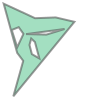

In [242]:
polyX = createPolygonWithInteriors(n_edges=7, n_interiors=3, n_edges_interiors=6, regular=False, convex=False, convexInteriors=False)
polyX

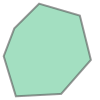

In [76]:
createConvexPolygon(7, regular = False)

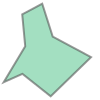

In [61]:
b

lvl 0 len(coords) 8 8
lvl 1 len(coords) 3 3
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F632E8FD0>]
lvl 1 len(coords) 7 7
lvl 2 len(coords) 3 3
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F633C8760>]
lvl 2 len(coords) 6 6
lvl 3 len(coords) 3 3
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F6342FDF0>]
lvl 3 len(coords) 5 5
lvl 4 len(coords) 3 3
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F6342F040>]
lvl 4 len(coords) 4 4
lvl 5 len(coords) 3 3
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F6342F8B0>]
lvl 5 len(coords) 3 3
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F6342F670>]


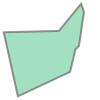

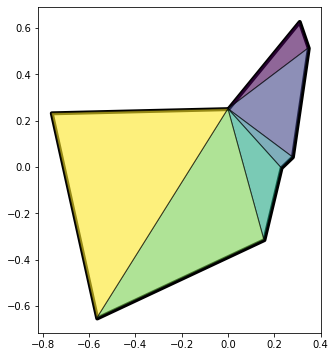

In [163]:
triangularize(b, plot=True)
b

In [234]:
len(b.exterior.coords)

13

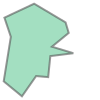

In [239]:
createPolygon(12, regular=False, convex=False)

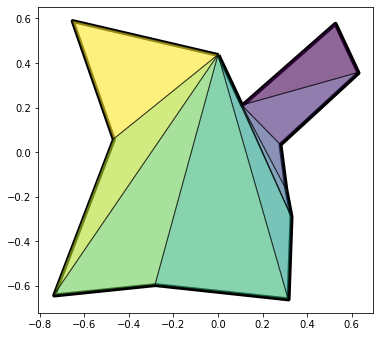

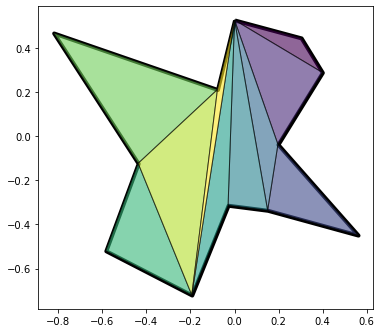

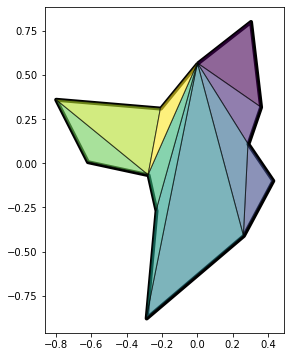

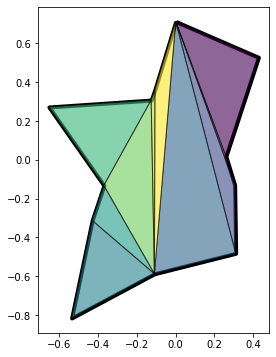

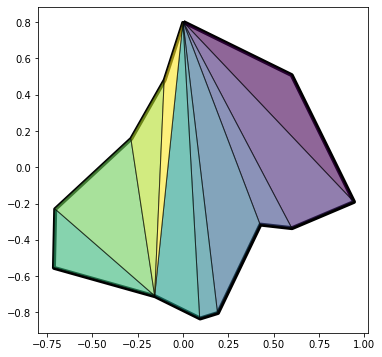

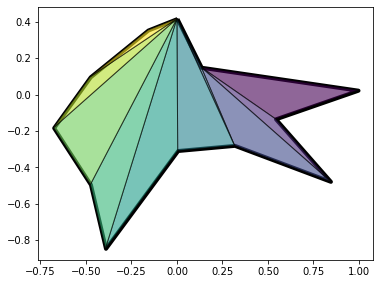

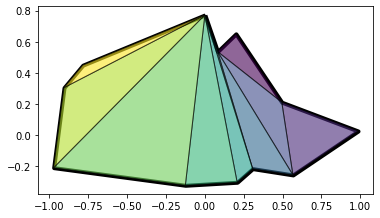

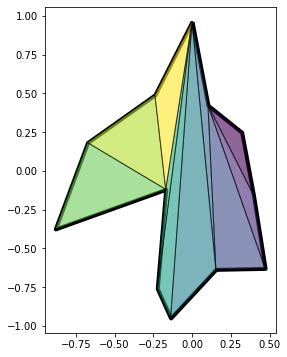

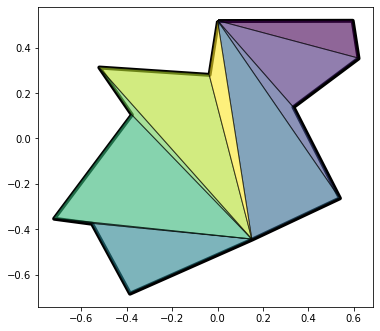

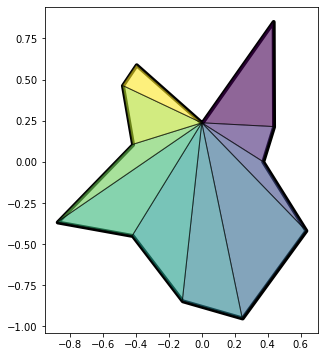

In [236]:
for i in range(10):
    b = createPolygon(12, regular=False, convex=False)
    a = triangularize(b, plot=True)
    if not len(a) == len(b.exterior.coords)-3:
        print("not")
        triangularize(b, plot=True)
        break

In [ ]:
i=0

<AxesSubplot:>

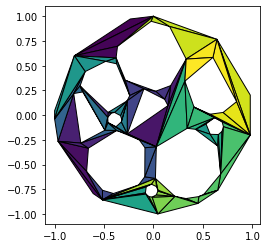

In [263]:
i = (i+1)%len(convexWithInterior)
gpd.GeoSeries([item for sublist in \
    [triangularize(x,plot=False) for x in splitPolygonToPolygonsWithoutInteriors(convexWithInterior[i],plot=False)]\
for item in sublist]).plot(cmap="viridis",edgecolor="black")

In [413]:
polyY=createPolygon(3, regular=False)
vector = ((np.random.random()-1)*2,(np.random.random()-1)*2)


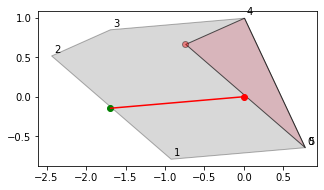

In [662]:
polyY=createPolygon(3, regular=False)
vector = ((np.random.random()-1)*2,(np.random.random()-1)*2)
# polyY=createPolygon(3, regular=False)
shadow = projectTriangleShadow(polyY.exterior.coords, vector)
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
gpd.GeoSeries([polyY]).plot(ax=axs, alpha=0.8,color="pink",edgecolor="black")
gpd.GeoSeries([shadow]).plot(ax=axs, alpha=0.3, color="grey", edgecolor="black")
gpd.GeoSeries([Point(polyY.exterior.coords[mostTowardsVector(polyY.exterior.coords,vector)])]).plot(ax=axs, alpha=0.4, color="red", edgecolor="black")
gpd.GeoSeries([LineString([(0,0),vector])]).plot(ax=axs, edgecolor="red")
gpd.GeoSeries([Point((0,0))]).plot(ax=axs, color="red")
gpd.GeoSeries([Point(vector)]).plot(ax=axs, color="green")
for x, y, label in zip([shadow.exterior.coords[x][0] for x in range(len(shadow.exterior.coords))], [shadow.exterior.coords[x][1] for x in range(len(shadow.exterior.coords))], [str(x) for x in range(len(shadow.exterior.coords))]):
    axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# for x, y, label in zip([interiorsCoords[i][x][0] for x in range(len(interiorsCoords[i]))], [interiorsCoords[i][x][1] for x in range(len(interiorsCoords[i]))], [str(x) for x in range(len(interiorsCoords[i]))]):
#     axs.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

<AxesSubplot:>

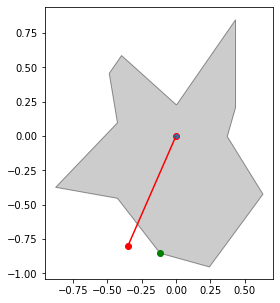

In [365]:

vector = (-.35,-0.8)
coords = [((x[0]*1000//10)/100, (x[1]*1000//10)/100) for x in b.exterior.coords]
# print(coords)
ind = mostTowardsVector(coords,vector)
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
gpd.GeoSeries([Polygon(coords)]).plot(ax=axs, alpha=0.4, color="grey", edgecolor="black")
gpd.GeoSeries([LineString([(0,0),vector])]).plot(ax=axs, edgecolor="red")
gpd.GeoSeries([Point((0,0))]).plot(ax=axs, edgecolor="red")
gpd.GeoSeries([Point(vector)]).plot(ax=axs, color="red")
gpd.GeoSeries([Point(coords[ind])]).plot(ax=axs, color="green")






In [199]:
len(list(set(b.exterior.coords)))

8

In [202]:
coords = [(0.0, 0.4884628828956418), (0.2111710084882388, 0.2904523353449734), (0.7187274665241035, 0.47166281246084607), (0.21605023498431686, -0.12025424500616477)]
Polygon(coords).contains(LineString([coords[1],coords[3]]))

True

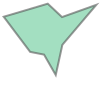

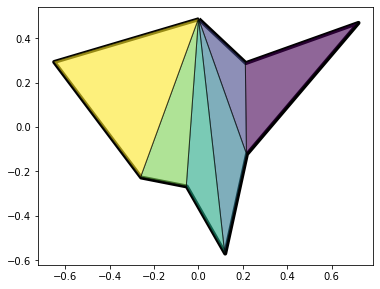

In [223]:
a = triangularize(b, plot=True)
b

In [84]:
a

In [101]:
a

coordRings [3, 7]
coordring
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F6164C790>]
coordring
coordRings [3, 6]
coordring
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F6198FD60>]
coordring
coordRings [3, 5]
coordring
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F62C2FF10>]
coordring
coordRings [3, 4]
coordring
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F62C2F250>]
coordring
coordRings [3, 3]
coordring
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F619B1D60>]
coordring
early return [<shapely.geometry.polygon.Polygon object at 0x0000020F619B1760>]


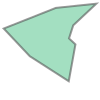

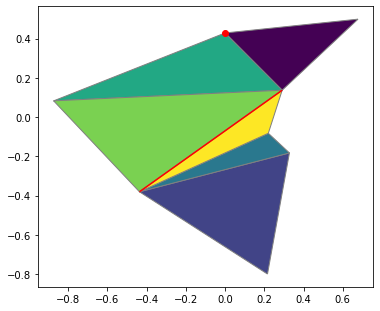

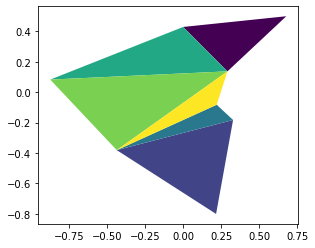

In [108]:
a= triangularize(b, plot=True)
gpd.GeoSeries(a).plot(cmap="viridis")
if(len(a) == len(b.exterior.coords)):
    print("dif size;",len(a), len(b.exterior.coords))
b


In [267]:
len(set(list(a[0].exterior.coords)))

2

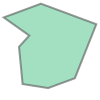

In [240]:
createPolygon(8, regular=False, convex=False)

<AxesSubplot:>

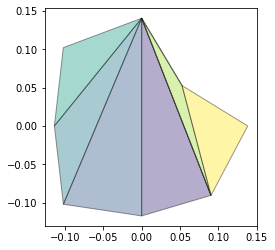

In [113]:
gpd.GeoSeries(a).plot(alpha=0.4, cmap="viridis", edgecolor="black")

In [22]:
i=0

extCoordsMod [(0.008560814680408518, -0.04027546650711509), (-0.011547048135730075, -0.054324590334952835), (-0.043831332975070525, -0.06032865425703905), (-0.032098956405190414, -0.045616991562626746), (-0.033639799086867005, -0.05011751350842252), (-0.03314412235504343, -0.05453469958087539), (-0.02896847296059088, -0.05552931587216188), (-0.025461684250794415, -0.056541290773368974), (0.008560814680408518, -0.04027546650711509)]
coordRings [[(0.008560814680408518, -0.04027546650711509), (-0.011547048135730075, -0.054324590334952835), (-0.043831332975070525, -0.06032865425703905), (-0.032098956405190414, -0.045616991562626746), (-0.033639799086867005, -0.05011751350842252), (-0.03314412235504343, -0.05453469958087539), (-0.02896847296059088, -0.05552931587216188), (-0.025461684250794415, -0.056541290773368974)]]
extCoordsMod [(-0.03314412235504343, -0.05453469958087539), (-0.03314412235504343, -0.05453469958087539), (-0.025461684250794415, -0.056541290773368974), (0.00856081468040851

c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


extCoordsMod [(0.008560814680408518, -0.04027546650711509), (0.008560814680408518, -0.04027546650711509), (0.008560814680408518, -0.04027546650711509), (0.008560814680408518, -0.04027546650711509), (0.008560814680408518, -0.04027546650711509), (-0.027399242976624577, -0.04484804069194827), (-0.032098956405190414, -0.045616991562626746), (-0.043831332975070525, -0.06032865425703905), (-0.04168044946782031, -0.02406421872019068), (0.008560814680408518, -0.04027546650711509), (-0.06183644584408793, -0.0064992723519902715), (-0.06848869248171761, 0.022253325156548605), (-0.0485968025244593, 0.04375675753296658), (-0.029849357213473166, 0.06704275397886382), (0.0, 0.08274262424012345), (-0.039001772565910205, 0.055161102753337535), (-0.04639208728021164, -0.008381633131789738), (0.008560814680408518, -0.04027546650711509)]


KeyboardInterrupt: 

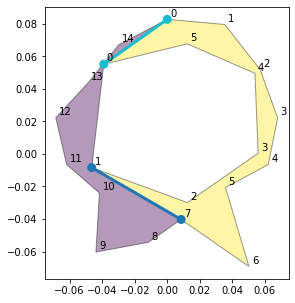

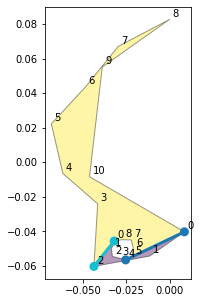

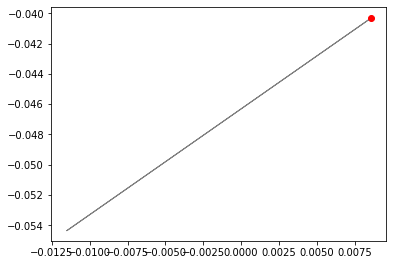

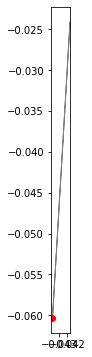

In [94]:
i = (i+1)%len(convexWithInterior)
gpd.GeoSeries([item for sublist in[triangularize(ply, plot=True) for ply in splitPolygonToPolygonsWithoutInteriors(convexWithInterior[i], plot=True)] for item in sublist]).plot(alpha=0.4, cmap="viridis", edgecolor="black")
convexWithInterior[i]

In [35]:
i = (i+1)%len(convexWithInterior)

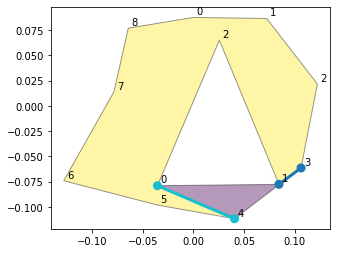

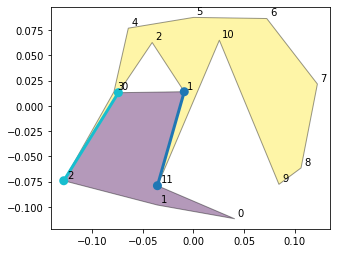

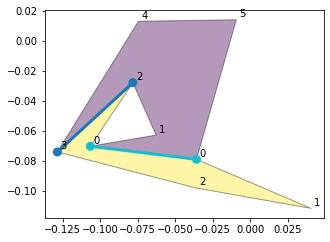

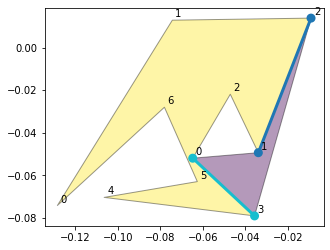

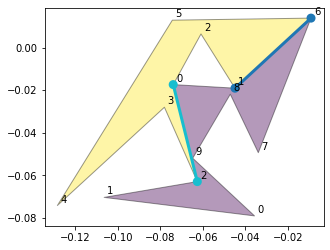

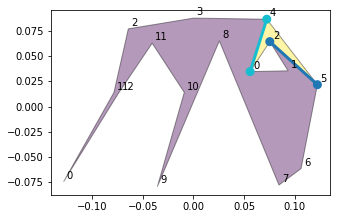

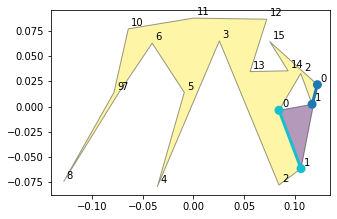

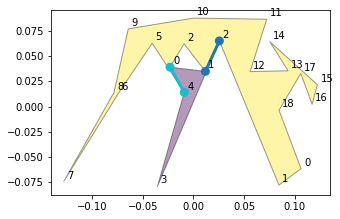

In [36]:
splitted = splitPolygonToPolygonsWithoutInteriors(convexWithInterior[i], plot=True)

<AxesSubplot:>

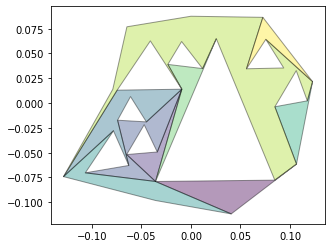

In [37]:
gpd.GeoSeries(splitted).plot(alpha=0.4, cmap="viridis", edgecolor="black")


In [27]:
j=0

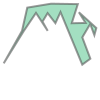

In [68]:
splitted[7]

In [48]:
len(splitted[j].exterior.coords)**2

484

In [55]:
l=32
(l//2 + (1 if (l+2)%4 == 0 else 0)) % l + (l+1)%2

17

In [72]:
j = (j+1)%len(splitted)
print("j=",j)
gpd.GeoSeries(triangularize(splitted[j], maxIteration= len(splitted[j].exterior.coords)**4)).plot(alpha=0.4, cmap="viridis", edgecolor="black")

j= 1


TypeError: unhashable type: 'list'

In [631]:
gpd.GeoSeries([item for sublist in [triangularize(ply, plot=False) for ply in splitted] for item in sublist]).plot(alpha=0.4, cmap="viridis", edgecolor="black")


4 4
0 0
5 5
4 4
0 0
6 6
0 0
9 9
8 8
7 7
6 6
5 5
0 0
4 4
0 0
36 36
33 33
32 32
26 25
26 24
26 24
26 24
23 21
22 20
20 18
17 15
17 15
17 14
16 13
16 13
16 13
16 13
16 13
14 11
13 10
12 9
21 to many


TypeError: 'NoneType' object is not iterable

In [213]:
(["j0","j","k0","k"][[2,34,5,7].index(2)],2)

('j0', 2)

In [488]:
definedClockwise([(1.5, 1.5), (1.5, 1.0), (1.0, 1.0), (1.5, 1.5)])

0.25


True

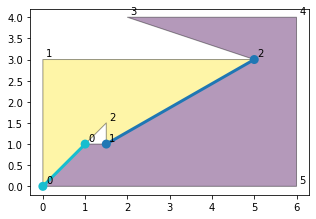

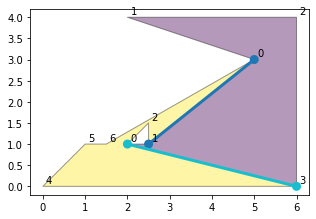

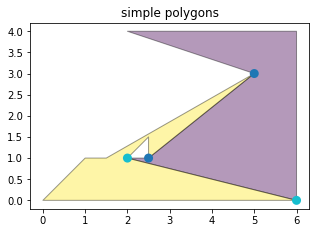

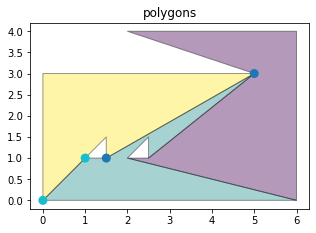

In [495]:
a= splitPolygonToPolygonsWithoutInteriors(polygon_1)

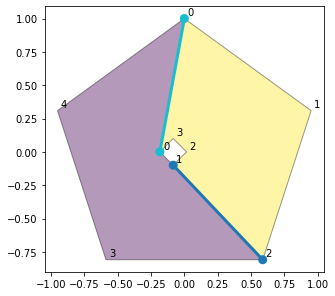

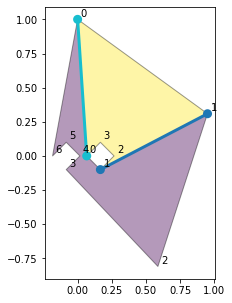

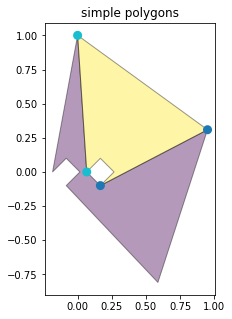

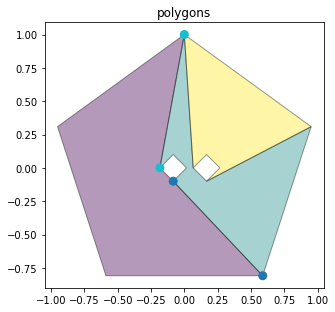

In [494]:
a = splitPolygonToPolygonsWithoutInteriors(poly5)

In [451]:
LineString([(0.5,0),(2,0)]).touches(Polygon([(0,0),(1,0),(1,1),(0,1)], [[(0.1,0.1),(.2,.1),(.2,.2),(.1,.2)]] ).interiors)

True

In [445]:
Polygon([(0,0),(1,0),(1,1),(0,1)], [[(0.1,0.1),(.2,.1),(.2,.2),(.1,.2)]] ).exterior.crosses(LineString([(.3,0),(2,0)]))
LineString([(0.5,0),(2,0)]).touches(Polygon([(0,0),(1,0),(1,1),(0,1)], [[(0.1,0.1),(.2,.1),(.2,.2),(.1,.2)]] ).exterior)

False

In [424]:
# if ((pol1.intersects(pol2) == False) and (pol1.disjoint(pol2) == True)) or ((pol1.intersects(pol2) == True) and (pol1.touches(pol2) == True)):
#     allowed = True
# elif (pol1.intersects(polMe) == True) and (pol1.disjoint(polMe) == False) and (pol1.touches(polMe) == False):
#     allowed = False
Polygon([(0,0),(1,0),(1,1),(0,1)]).touches(LineString([(.3,.3),(2,1)]))

False

In [414]:
Polygon([(0,0),(1,0),(1,1),(0,1)], [[(0.1,0.1),(.2,.1),(.2,.2),(.1,.2)]] ).covers(LineString([(.1,.1),(.21,.1)]))

True

In [399]:
LineString([(.1,.1),(.1,.5)]).intersects(Polygon([(0,0),(1,0),(1,1),(0,1)], [[(0.1,0.1),(.2,.1),(.2,.2),(.1,.2)]] ))

True

[(0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (2.0, 4.0), (6.0, 4.0), (6.0, 0.0)]
41.0
[(1.0, 1.0), (1.5, 1.0), (1.5, 1.5)]
1.0
[(2.0, 1.0), (2.5, 1.0), (2.5, 1.5)]
1.0
clockwise ext True interiors [True, True]
[(0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (2.0, 4.0), (6.0, 4.0), (6.0, 0.0)]
41.0
[(1.0, 1.0), (1.5, 1.0), (1.5, 1.5)]
1.0
k0,k 1 0 len splitExt [6, 7] 
 j0,j 0 1 len splitInt [2, 3]
[(1.5, 1.5), (1.5, 1.0), (1.0, 1.0)]
-1.0
[(0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (2.0, 4.0), (6.0, 4.0), (6.0, 0.0)]
41.0
int clock: False extclock: True
sE0 [('k', (0.0, 0.0)), ('k0', (0.0, 3.0)), ('j0', (1.5, 1.5)), ('j', (1.5, 1.0))]
sE1 [('k0', (0.0, 3.0)), '-', '-', '-', '-', ('k', (0.0, 0.0)), ('j', (1.5, 1.0)), '-', ('j0', (1.5, 1.5))]
[(0.0, 3.0), (5.0, 3.0), (2.0, 4.0), (6.0, 4.0), (6.0, 0.0), (0.0, 0.0), (1.5, 1.0), (1.0, 1.0), (1.5, 1.5)]
42.75
[(2.0, 1.0), (2.5, 1.0), (2.5, 1.5)]
1.0
clockwise ext True interiors [True]
[(0.0, 3.0), (5.0, 3.0), (2.0, 4.0), (6.0, 4.0), (6.0, 0.0), (0.0, 0.0), (1.5, 1.0),

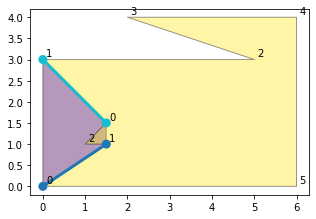

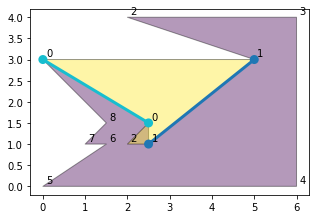

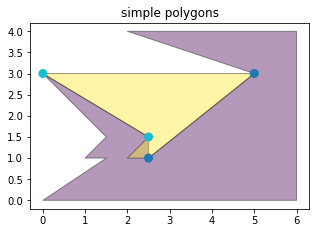

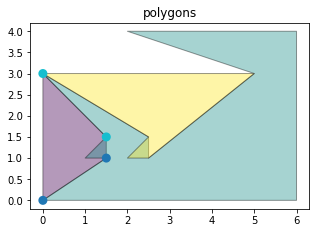

In [387]:
a = splitPolygonToPolygonsWithoutInteriors(poly)

In [374]:
# definedClockwise([(1,1),(0,1),(0,0)])
definedClockwise([(0,0),(0,1),(1,1)])

[(0, 0), (0, 1), (1, 1)]
2


True

In [367]:
definedClockwise([(1,1),(1,0),(0,0)])

False

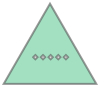

In [11]:
createConvexPolygonWithConvexInteriors(n_edges=3, n_interiors=5, n_edges_interiors=4)

arr0 [(1.5, 1.5), (0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0)]
res0 [(0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0), (1.5, 1.5), (0.0, 0.0)]
res1 [[(0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (1.5, 1.0), (1.5, 1.5), (0.0, 0.0)]]
res2 [[(0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]]
res3 [[(0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]]
res [[(0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]]


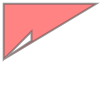

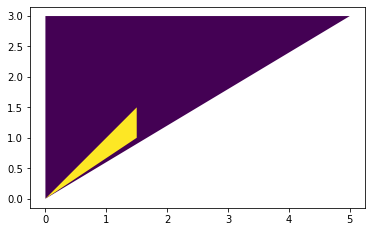

In [16]:
coords = [(1.5, 1.5), (0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0)]

# Polygon(addSelfIntersectingCoords(coords))
gpd.GeoSeries([Polygon(x) for x in splitToValidCoordinateRings(coords)]).plot(cmap="viridis")
Polygon(coords)

In [22]:
list(poly.interiors[0].coords)

[(1.0, 1.0), (1.5, 1.0), (1.5, 1.5), (1.0, 1.0)]

In [ ]:
list(poly.exterior.coords)

[(0.0, 0.0),
 (0.0, 3.0),
 (5.0, 3.0),
 (2.0, 4.0),
 (6.0, 4.0),
 (6.0, 0.0),
 (0.0, 0.0)]

In [21]:
gpd.GeoSeries(triangularize(createConvexPolygon(5))).plot(alpha=0.4,cmap = 'Reds', edgecolor = 'black')

poly.boundary.coords [(0.0, 1.0), (0.9510565162951535, 0.30901699437494745), (0.5877852522924732, -0.8090169943749473), (-0.587785252292473, -0.8090169943749475), (-0.9510565162951536, 0.30901699437494723), (0.0, 1.0)]
coordsWithIntersectionPoints [(0.0, 1.0), (0.9510565162951535, 0.30901699437494745), (0.5877852522924732, -0.8090169943749473), (-0.587785252292473, -0.8090169943749475), (-0.9510565162951536, 0.30901699437494723)]
arr0 [(0.0, 1.0), (0.9510565162951535, 0.30901699437494745), (0.5877852522924732, -0.8090169943749473), (-0.587785252292473, -0.8090169943749475), (-0.9510565162951536, 0.30901699437494723)]
poly.boundary.coords [(0.0, 1.0), (0.9510565162951535, 0.30901699437494745), (0.5877852522924732, -0.8090169943749473), (-0.587785252292473, -0.8090169943749475), (-0.9510565162951536, 0.30901699437494723), (0.0, 1.0)]
coordsWithIntersectionPoints [(0.0, 1.0), (0.9510565162951535, 0.30901699437494745), (0.5877852522924732, -0.8090169943749473), (-0.587785252292473, -0.8090

OSError: exception: stack overflow

<AxesSubplot:>

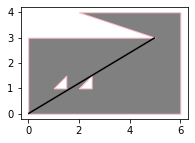

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
gpd.GeoSeries([poly]).plot(ax=axs, color = "grey", edgecolor="pink")
gpd.GeoSeries([LineString([poly.exterior.coords[0],poly.exterior.coords[2]])]).plot(ax=axs, color = "black")

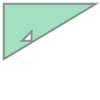

In [12]:
Polygon(poly.exterior.coords[0:3], [poly.interiors[0]])

In [23]:
gpd.GeoSeries(triangularize(Polygon(poly.exterior.coords[0:3], [poly.interiors[0]]), plot=True)).plot(alpha=0.4,cmap = 'Reds', edgecolor = 'black')

c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


[(0, <shapely.geometry.polygon.Polygon object at 0x0000019CE4D8AB20>), (2, <shapely.geometry.polygon.Polygon object at 0x0000019CE6DE7A30>)]
indexedTriangle indexes [0, 2]
interiorCoords [(1.0, 1.0), (1.5, 1.0), (1.5, 1.5)]
modCoords [[(0.0, 0.0)], [(1.5, 1.0)], [(0.0, 0.0), (1.5, 1.5)]]
openedInteriors [[(0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]]
extCoordsMod [(0.0, 0.0), (0.0, 3.0), (5.0, 3.0)]
openedInteriors sorted [[(0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]]
coordsMod [(0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]
untouchedInteriors []
poly.boundary.coords [(1.5, 1.5), (0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0), (1.5, 1.5)]
coordsWithIntersectionPoints [(1.5, 1.5), (0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0)]
arr0 [(1.5, 1.5), (0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0)]
res0 [(0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (1.5, 1.0), (1.5, 1.5), (0.0, 0.0)]
res1 [[(0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (1.5, 1.0), (1.5, 

: 

: 

In [ ]:
len(range(2,10-1))

7

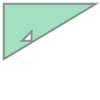

In [ ]:
Polygon(poly.exterior.coords[:3], [poly.interiors[0]])

In [ ]:
[(i,(20,30)) for i in range(0, 10) if not i in [2,3,4,6]][4][1][1]

30

In [ ]:
Polygon([(0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (2.0, 2.5), (2.5, 2.5), (2.25, 2.0)]).exterior.crosses(LineString([(0,0),(1,1)]))

False

In [ ]:
poly.crosses(LineString([(0,0),(1,1)]))

In [ ]:
Polygon(poly.exterior.coords[:3], [[(2.25,2),(2,2.5),(2.5,2.5)]]).contains(LineString([(0,0),(1,1)]))

True

[(0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0)]


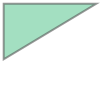

In [ ]:
poly2 = Polygon(Polygon([(0.0, 0.0), (0.0, 3.0), (5.0, 3.0)])).difference(Polygon([(0.0, 0.0), (2.0, 2.5), (2.5, 2.5), (2.25, 2.0)]))
print(list(poly2.exterior.coords))
Polygon(list(poly2.exterior.coords))

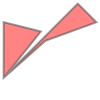

In [ ]:
Polygon([(0.0, 3.0), (2.0, 2.5), (0.0, 0.0), (2.25, 2.0), (5.0, 3.0), (0.0, 0.0)])

In [ ]:
arr[:arr.index(max(set(arr)))]+arr[arr.index(max(set(arr))):]

[(3, 0),
 (2, 0),
 (4, 4),
 (3, 1),
 (5, 5),
 (3, 3),
 (3, 1),
 (1, 1),
 (4, 4),
 (2, 1),
 (4, 4)]

In [ ]:
arr =list(range(10))
arr = arr[(arr.index(3)+1)%len(arr):]+arr[:(arr.index(3)+1)%len(arr)]
arr

[4, 5, 6, 7, 8, 9, 0, 1, 2, 3]

In [ ]:
arr =[1,3,1]
print(len(arr),len(set(arr)))

3 2


In [ ]:
# [LineString(b[k:k+2]) for k in range(len(b) - 1)]
poly4=Polygon([(0,0),(1,1),(1,0),(0,1)])
coords = poly4.exterior.coords
edges = [LineString(coords[k:k+2]) for k in range(len(coords) - 1)]
# intersections = [(i,[item for sublist in [list(edge.intersection(edges[j]).coords) for j in range(len(edges))if not i == j and edge.crosses(edges[j])].sorted() for item in sublist]) for i,edge in enumerate(edges) ]
# print(intersections)
# sorted([2,4,2,4,6,2,1], key = lambda x: x%3)
# sort intersection such that [closestToFirstCoordinate, ..., closestToNextCoordinate]
newCoords = [item for sublist in [[coords[i]]+\
    [item for sublist in \
    [sorted(list(edges[i].intersection(edges[j]).coords),\
    key=lambda intersec: -abs(coords[i][0]-intersec[0] + coords[i][1]-intersec[1]))\
    for j in range(len(edges))if not i == j and edges[i].crosses(edges[j])] \
    for item in sublist] \
    for i in range(len(coords)-1)] \
    for item in sublist]
print(newCoords)
# gpd.GeoSeries(intersections).plot(cmap="viridis")

[(0.0, 0.0), (0.5, 0.5), (1.0, 1.0), (1.0, 0.0), (0.5, 0.5), (0.0, 1.0)]


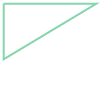

In [ ]:
LineString(list(poly2.boundary[0].coords))
poly2.boundary[0]

In [ ]:
list(poly.boundary[0].coords) == list(poly.exterior.coords)
# poly.exterior
# poly.boundary[0]

True

In [ ]:
type(LineString([(0,0),(1,1)]))==LineString

True

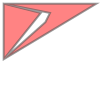

In [ ]:
Polygon([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

In [ ]:
addSelfIntersectingCoords([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

coordsWithIntersectionPoints [(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0)]


[(0.0, 0.0),
 (2.25, 2.0),
 (2.5, 2.5),
 (0.0, 3.0),
 (5.0, 3.0),
 (0.0, 0.0),
 (0.0, 3.0)]

In [ ]:
splitToValidCoordinateRings([(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)])

arr0 [(0.0, 0.0), (2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]
res0 [(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (0.0, 3.0), (2.0, 2.5), (0.0, 0.0)]
res1 [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5), (0.0, 0.0)]]
res2 [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]
res3 [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]
res [[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]


[[(2.25, 2.0), (2.5, 2.5), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0)],
 [(0.0, 0.0), (0.0, 3.0), (2.0, 2.5)]]

In [ ]:
gpd.GeoSeries(triangularize(poly2, plot=True)).plot(alpha=0.4,cmap = 'Reds', edgecolor = 'black')

NameError: name 'poly2' is not defined

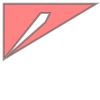

In [ ]:
Polygon([(0.0, 0.0), (0.0, 3.0), (5.0, 3.0), (0.0, 0.0), (2.0, 2.5), (2.5, 2.5), (2.25, 2.0)])

In [ ]:
gpd.GeoSeries(triangularize(Polygon(poly.exterior.coords[:3], [[(2.25,2),(2,2.5),(2.5,2.5)]]), plot=True)).plot(alpha=0.4,cmap = 'Reds', edgecolor = 'black')

c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\BSE\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

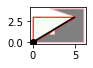

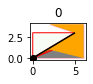

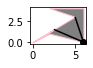

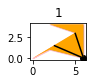

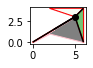

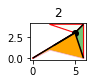

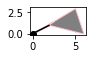

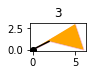

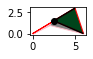

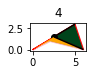

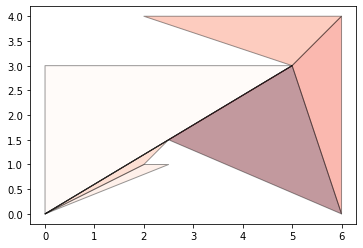

In [ ]:
gpd.GeoSeries(triangularize(poly, plot=True)).plot(alpha=0.4,cmap = 'Reds', edgecolor = 'black')

In [102]:
for el in enumerate(["A","B"]):
    print(list(el)+[2])

[0, 'A', 2]
[1, 'B', 2]


In [ ]:
# each coordinate other than coords[0] has 2 "lifes". 
# if it gets removed twice it can be removed from polygon that needs to be processed for shadow projection as its included in two triangles
# coords[0] has len(coord)-3 lifes before removed

In [ ]:
def produceTriangleList (startCoord, midCoord, endCoord, prevCoord, nextCoord, poly):
    if(poly.crosses(LineString([startCoord, endCoord]))):
        intersectionCoords = [prevCoord, startCoord]+[list(point.coords) for point in inters.boundary]+[endCoord, nextCoord]
        return [item for sublist in [produceTriangleList(i) for i in range(len(intersectionCoords)-2)] for item in sublist]
    else:
        return [Polygon([startCoord, midCoord, endCoord])]


#isLeft(a, b, c):
#     return ((b.X - a.X)*(c.Y - a.Y) - (b.Y - a.Y)*(c.X - a.X)) > 0;
#

In [35]:
def returnTriangleListFromPolygon (poly:Polygon):
    coords = []
    if(len(poly.interors)==0):
        coords = list(poly.exterior.coords)
    if(len(coords<6) and len(set(coords)<3)):
        return []
    triangleList, irregular = [], False
    # always connect i with i + 2
    # check whether the connection line intersects polygon
    
    if(coords)
    # if not then create triangle
    #     if it passes point check whether trianle is in original polyogon by mixing Point(coodsxy1*1/3+coodsxy2*1/3+coodsxy3*1/3)
    #     else dont create it
    # else set irregular = True
    # then create at n_intersections + 1 triangles 
    # for which later it needs to be checked whether they are part of orginal poly or not
    # two are easily created Polygon(start coord, previous coord, first intersection) and  Polygon(end coord, next coord, last intersection) 
    # for the remaing n_intersections -1 triangles it needs to be derived what the 3rd point is
    [i for i in range(len(coords)-2)]
    
    return 0


In [184]:
def getEdgesFromCoords (coords:list):
    """
    Create Linestrings between each coords and the following coordinate (last is connected to first) 
    Returns Linestrings in List
    """
    # 2do: Problem! there might be groups of edges (hole in the shape) 
    # thus not all points shall be connected
    # only points within groups of edges
    # len(list(geom.interiors)) == 0 # no holes
    # Solve by taking a list of coords as Input and 
    # return [[LineString( ???(coords if coords[0] == coords[-1] else coords + [coords[0]])???[i:i+2]) for i in range(len(coords) - 1)] for coords in coordSets]
    if coords[0] != coords[-1]:
        coords = coords + [coords[0]]
    return [LineString( coords[i:i+2]) for i in range(len(coords) - 1)]
#

In [81]:
def isDescending (edgeCoords:list):
    if(edgeCoords[0][0] == edgeCoords[1][0]):
        return edgeCoords[0][1] > edgeCoords[1][1]
    else: 
        return edgeCoords[0][0] > edgeCoords[1][0]
#

In [82]:
def createLinesFromCoords (coords:list):
    """
    Create Linestrings between each coords and the following coordinate (last is connected to first) 
    Returns Linestrings in List
    ATTENTION: IT SEEMS LIKE THE OLD VERSION DIDNT CONNECT THE LAST TO FIRST COORDINATE (NOT CLOSING POLYGON). FOR ANY REASON?
    ATTENTION: WHY ARE WE SORTING?
    ATTENTION: IS IT A PROBLEM TO GET RID OF DUPLICATE COORDINATES IN CASE THERE ARE WEIRDLY SHAPED POLYGONS?
    """
    # ATTENTION: IT SEEMS LIKE THE OLD VERSION DIDNT CONNECT THE LAST TO FIRST COORDINATE (NOT CLOSING POLYGON)
    # coords = list(set(coords))
    coords.sort(reverse = isDescending(coords))
    # lines = []
    # for coordIndex in range(len(coords) - 1):
        # newLine = LineString([coords[coordIndex], coords[coordIndex + 1]])
        # lines.append(newLine)
    # return lines
    return [LineString( (coords if coords[0] == coords[-1] else coords + [coords[0]])[i:i+2]) for i in range(len(coords) - 1)]
#

In [83]:
# def splitLineWithEdges (line:LineString, edges:list):
#     """OLD FUNCTION THAT IS NOT USEFULL AS IT IS"""
#     # loop through all edge to evaluate whtether there has been an intersection
#     lineCoords = list(line.coords)
#     for edge in edges:
#         if(line.intersects(edge)):
#             # if there has been an intersection cut edge in two parts
#             lineCoords += list(edge.intersection(line).coords)
#     return edges
#

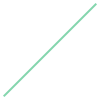

In [219]:
LineString([(1,2), (3,4)])

In [224]:
l = list([[ LineString([(1,2), (3,4) ]) ]])
l
[item for sublist in l for item in sublist]

In [ ]:
def splitEdgeAlongLine (edge:LineString, line:LineString):
    if(edge.crosses(line)):
        # if there has been an intersection cut edge in two parts
        edgeIntersectionCoords = list(edge.intersection(line).coords)
        edgeCoords = list(set(list(edge.coords) + edgeIntersectionCoords))
        splittedEgdeParts = createLinesFromCoords(edgeCoords)
        return splittedEgdeParts
    else: 
        return [edge]
#

In [228]:
lines = []
for i in range(10):
    lines.append(LineString([(np.random.random(2)), (np.random.random(2))]))


In [295]:
for i in range(5000):
    [item for sublist in [[[y]] if y==1 else [] for y in np.random.randint(0,2,1000) if y==1] for item in sublist]

In [302]:
[item for sublist in [[1,2],[3,4],[]] for item in sublist]

[1, 2, 3, 4]

In [304]:
[edge for edge in [0,2,3,4,5] if edge not in [1,2,3,4]]

[0, 5]

In [296]:
for i in range(5000):
    [item for item in [[y] if y==1 else [] for y in np.random.randint(0,2,1000) if y==1]]

In [235]:
def splitEdgesAlongLine (edges:list, line:LineString, plot:bool = False):
    """
    Splits edges that cross a line, remove orignal edge from edges and add the seperate edge
    return potentially modified list of edges
    """
    oldEdges = edges
    # loop through all edges to evaluate whtether there has been an intersection
    edges = [item for sublist in [splitEdgeAlongLine(edge, line) for edge in edges] for item in sublist]
    [x for x in array if x==x ]

    if(len(edges)<len(oldEdges)-1):
        print("edges removed!")
    
    if(plot):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        gpd.GeoSeries(oldEdges).plot(ax=axs, color="red")
        gpd.GeoSeries(edges).plot(ax=axs, color="blue")
        edgesToAdd = [edge for edge in edges if edge not in oldEdges]
        gpd.GeoSeries(edgesToAdd).plot(ax=axs, color="green")
        gpd.GeoSeries([line]).plot(ax=axs, color="black")
        fig.suptitle('Spliting (green) edge at (black) line')    

    return edges
#

In [85]:

def angleToNorth (point1:tuple = (0,0), point2:tuple = (0,0)):
    """
    point1 and point2 each must be a tuple of point coords eg. (0,1)
    return angle to north ((0,0) to (0,1))
    """
    xDiff = point2[0] - point1[0]
    yDiff = point2[1] - point1[1]
    
    if(xDiff == 0):
        angle = 0 if(yDiff > 0) else 180
    else:
        angle = -math.atan(yDiff / xDiff) * 180 / math.pi + (270 if(xDiff<0) else 90)
    
    return angle
#

In [15]:
def addOne (e):
    return e

In [23]:
it = 1000
arrlen = 100000

In [32]:
for i in range(it):
    l=[addOne(x) for x in range(arrlen)]

In [33]:
for i in range(it):
    l = [None]*arrlen
    for j in range(arrlen):
        l[j] = addOne(j)

In [31]:
for i in range(it):
    l=[x for x in range(arrlen)]

In [34]:
for i in range(it):
    l = [None]*arrlen
    for j in range(arrlen):
        l[j] = j

In [86]:
def clockwiseAngle (firstAngle, secondAngle):
    """
    returns the outer angle in clockwise direction
    thus 180° if angles are equal
    """
    return (secondAngle - firstAngle + 540) % 360
#

In [87]:
def plotGeometry (geometryList:list, axs = None, color:str = "", cNr:int = None, label:bool = False):
    """
    plot a list of geometries. input:
        geometryList = list of geometries
        axs = plot index, if not specified it directly plots
        color = if specified it determines the color of geometry
        cNr = (if no color) species color map ['tab20', 'Set3', 'Set1', 'tab20b', 'tab20c', 'gist_ncar'][cNr].  
    """
    
    if( type(geometryList) != list or (len(geometryList) == 0) ):
        print('can not plot geometry: no valid list of geometries provided.')
        return
    
    p = gpd.GeoDataFrame(range(len(geometryList)))
    p.columns = ['nr']
    p['geometry'] = geometryList
    cmaps = ['tab20', 'Set3', 'Set1', 'tab20b', 'tab20c', 'gist_ncar']
    if(color):
        if(color not in cmaps):
            p.plot(ax = axs, color = color, edgecolor = '#000')
        else:
            p.plot(ax = axs, cmap = color, column = 'nr')
    else:
        cmap = cmaps[cNr]
        p.plot(ax = axs, cmap = cmap, column = 'nr')
    if(axs and label):
        p.apply(
            lambda x: axs.annotate(text=x.nr, xy=x.geometry.centroid.coords[0], ha='center'), axis=1
        )
#

In [88]:

def orderPresentInArray (el1, el2, listOfLists:list):
    """
    check if el1 and el2 are included in any list within listOfLists array AND
    that el2 directly follows el1
    including possibility of [el2, ...,el1]
    returns bool
    ATTENTION: UNDERSTAND WHY WE ARE LOOKING AT NESTED ARRAY
    """
    return len(
        [x for x in listOfLists if 
         el1 in x and 
         el2 in x and 
         (
             x.index(el1) == x.index(el2) - 1 or
             (
                 x.index(el1) == len(x) - 1 and 
                 x.index(el2) == 0)
             )
         ]
        ) > 0
#

In [89]:

def findNextVertex (currentPath:list, polygonPaths:list, verticesNetworkMatrix, vertices:list):
    """
    nested function that tries to find a path that encloses a polygon within which no other polygon lies
    idea: we only follow path in clockwise motion
    then the best way to close polygon is follow the line wich goes 
    back from which the last edge came from. 
    the angle thus needs to be maximized but still follow the clockwise definition

    currentPath needs to be at least of length 2
    currentPath entries are indices referring to a vertex

    """
    # problem: outline path is still included # idea: could be solved if always going the wrong outside way
    
    # all other vertices that are connected to this vertex
    lastVertex = currentPath[-2]
    currentVertex = currentPath[-1]
    connectedVertices = [x[0] for x in [x for x in enumerate(verticesNetworkMatrix[currentVertex]) if x[1]]]
    
    angleLastEdge = angleToNorth(vertices[lastVertex], vertices[currentVertex])
    #
    angles = np.array(list(map(
        lambda x: clockwiseAngle(
                       firstAngle = angleLastEdge, 
                       secondAngle= angleToNorth(vertices[currentPath[-1]], vertices[x])
                       ), connectedVertices)))
    nextVertex = connectedVertices[angles.argmax()]
    # check if nextVertex already followed nextVertex in a polyognPaths
    
    usedBefore = orderPresentInArray(currentVertex, nextVertex, polygonPaths)
    
    if(not usedBefore):
        # check if path is closed
        isClosed = nextVertex == currentPath[0]
        if(not isClosed):
            currentPath.append(nextVertex)
            findNextVertex(currentPath, polygonPaths, verticesNetworkMatrix, vertices)
        else:
            # append path to polygonPahts
            polygonPaths.append(currentPath)
#

# Define shadow projection for single Polygons

In [90]:
def projectShadow (geom:Polygon, height:float, lat:float, long:float, date:datetime, method:str = "manual", showPlots:bool = False):
    """
    return shadow geometry
    takes in original geometry, its height, lat, long, date-time
    method: 
        "difference" (fastest) adds buffers to edges ad substracts these polygons from hull using shapely
        "polygonize" (2nd fastest) uses shapely's 'polygonize' to derive individual polygons
        "manual" (slowest) manually programmed solution to detect individual polygons
    """

    # get list of coords
    coords = list(geom.exterior.coords)
    # get edges for ext
    edges = getEdgesFromCoords(coords)
    # add edges and coordinates of possible interiors (holes in shape)
    for interior in list(geom.interiors):
        interiorCoords = list(interior.coords)
        interiorEdges = getEdgesFromCoords(interiorCoords)
        coords += interiorCoords
        edges += interiorEdges
    
    # calculate angle between sun and earth surface at location and date
    altitude = solar.get_altitude(
        latitude_deg = lat, 
        longitude_deg = long, 
        when = date
        ) 
    # calculate direction of sunlight at location and date
    azimuth = solar.get_azimuth(
        latitude_deg = lat, 
        longitude_deg = long, 
        when = date
        )
    # length of the shadow
    shadowLengthUnitStick = 1 * math.tan( (90 - altitude) * math.pi / 180)
    shadowLength = height * shadowLengthUnitStick
    
    # remember: azimuth gives direction where sun comes from: 
    # shadow are projected in the opposite direction
    # if azimuth between 0° and 180° positive (= shadow goes east), else negative
    longShare = - math.sin((azimuth) * math.pi / 180)
    # if azimuth between 90° and 270° negative (= shadow goes south) else negative
    latShare = - math.sin((azimuth - 90) * math.pi / 180)
    
    scaleMetersToDegrees = 1 # projection already is in meters
    xoff = shadowLength * longShare / scaleMetersToDegrees
    yoff = shadowLength * latShare / scaleMetersToDegrees
    
    # shift footprint along shadow line (=shifter)
    geomShifted = translate(
        geom = geom, 
        xoff = xoff, 
        yoff = yoff
        )
    
    coordsShifted = list(geomShifted.exterior.coords)
    edgesShifted = getEdgesFromCoords(coordsShifted)
    # add edges and coordinates of possible interiors (holes in shape)
    for interior in list(geomShifted.interiors):
        interiorCoords = list(interior.coords)
        interiorEdges = getEdgesFromCoords(interiorCoords)
        coordsShifted += interiorCoords
        edgesShifted += interiorEdges
        
    # get shifters (connecting point of original geometry to respective point in projection)
    # shifters = []    
    # for coordIndex in range(len(coords)-(coords[0]==coords[-1])):
    #     shifter = LineString([coords[coordIndex], coordsShifted[coordIndex]])
    #     shifters.append(shifter)
    shifters = [LineString([coords[i], coordsShifted[i]]) for i in range(len(coords)-(coords[0]==coords[-1]))]
    
    
    # plot polygons, edges and shifters
    if(showPlots):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        plotGeometry([geom], axs, "#ccccccaa")
        plotGeometry([geomShifted], axs, "#ccccccaa")
        plotGeometry(edges, axs, "blue")
        plotGeometry(edgesShifted, axs, "green")
        plotGeometry(shifters, axs, "orange")
        fig.suptitle('geom (blue), geomShifted (green) and shifters (orange)')
    
    # divide edges at each intersction with other edges
    if(method != "difference"):
        # sect intersection of shifters with geoms
        intersectionCoords = []
        shiftersToRemove = []
        shiftersToAdd = []
        # account for intersections along between geom and geomShifted with Shifters lines
        for coordIndex in range(len(coords)-1):
            
            shifter = shifters[coordIndex]
            shifterCoords = list(shifter.coords)
            
            if(geom.crosses(shifter)):
                # print('crosses geom')
                # there is a mistake here. intersection can be point only
                intersections = geom.intersection(shifter)
                # print('intersections.type' , intersections.type)
                if(intersections.type in ['LineString', 'Point']):
                    intersections = [intersections]
                for intersection in intersections: 
                    # if(intersection.type == 'Point'):
                    #     print('point only')
                    #     continue

                    # 2DO: THERE SEEMS TO BE A MISTAKE WITH intersectionCoords, check scoping 

                    intersectionCoords = list(intersection.coords)
                    shifterCoords += intersectionCoords
                    intersectionCoords += intersectionCoords
                    # split original edges along shifter 
                    edges = splitEdgesAlongLine(edges, shifter)
                
            #
            if(geomShifted.crosses(shifter)):
                # print('crosses geomShifted')
                intersections = geomShifted.intersection(shifter)
                # print('intersections.type' , intersections.type)
                if(intersections.type in ['LineString', 'Point']):
                    intersections = [intersections]
                for intersection in intersections: 
                    # if(intersection.type == 'Point'):
                    #     print('point only')
                    #     continue
                    intersectionCoords = list(intersection.coords)
                    shifterCoords += intersectionCoords
                    intersectionCoords += intersectionCoords
                    # split shifted edges along shifter 
                    edgesShifted = splitEdgesAlongLine(edgesShifted, shifter)
    
            # if the shifter has intersections with one of the two polygons        
            shifterCoords = list(set(shifterCoords))
            if(len(shifterCoords) > 2):
                shiftersToRemove.append(shifter)
                # 2DO: check whether isDescending resolves the issue of bad ordering of coordinates
                shifterCoords.sort(reverse = isDescending(shifterCoords))
                for shifterIndex in range(len(shifterCoords) - 1):
                    # print("add 1 shifter")
                    shiftersToAdd.append(
                        LineString(
                            [shifterCoords[shifterIndex], 
                             shifterCoords[shifterIndex + 1]]
                            )
                        )
                #
            #
        #
        shifters = [x for x in shifters if x not in shiftersToRemove] + shiftersToAdd
        

        # account for intersections between geom and geomShifted
        if(geom.intersects(geomShifted) and (not geom.touches(geomShifted))):
            edgesToRemove = []
            edgesToAdd = []
            for edge in edges:
                if(edge.crosses(geomShifted)):
                    # print("edge crossses---")
                    addEdges = []
                    # split edge along Edges Shifted
                    for edgeShifted in edgesShifted:
                        # if(edge.intersects(edgeShifted)): print(edge.crosses(edgeShifted), edge.intersects(edgeShifted), not edge.touches(edgeShifted))
                        if(edge.intersects(edgeShifted) and (not edge.touches(edgeShifted))):
                            addEdges = splitEdgesAlongLine([edge], edgeShifted)
                        #
                    #
                    edgesToAdd += addEdges
                    edgesToRemove.append(edge)
                    # split edgesShifted
                    edgesShifted = splitEdgesAlongLine(edgesShifted, edge)
                
                #
            edges = [x for x in edges if not x in edgesToRemove] + edgesToAdd
            #
        #

        # account for intersections in shifters (=overlaps eg. [(0,0),(2,2)] with [(1,1),(3,3)])
        # might be expensieve. do only if offset
        shiftersToRemove = []
        shiftersToAdd = []
        for shifterIndex in range(len(shifters)):
            shifter = shifters[shifterIndex]
            for otherShifter in (shifters[:shifterIndex] + shifters[shifterIndex+1:]):
                if(shifter.intersects(otherShifter) and (not shifter.touches(otherShifter))):
                    # print("intersection")
                    shifter.intersection(otherShifter)
                    shiftersToRemove.append(otherShifter)
                    shiftersToRemove.append(shifter)
                    intersectionCoords = list(shifter.intersection(otherShifter).coords)
                    newCoords = intersectionCoords + list(shifter.coords)+ list(otherShifter.coords)
                    shiftersToAdd += createLinesFromCoords(newCoords)
        shifters = [x for x in shifters if not x in shiftersToRemove] + shiftersToAdd
        
        # if(showPlots):
        #     n=0
        #     fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        #     plotGeometry(edges, axs, '', 0)
        #     plotGeometry(edgesShifted, axs, '', 1)
        #     plotGeometry(shifters, axs, '', 5)
        #     plotGeometry( list(map(
        #         lambda x: Point(x), 
        #         list(map(lambda x: list(x.coords)[0], shifters)) + list(map(lambda x: list(x.coords)[1], shifters))
        #         )), axs, '#00ffff00', 0)
        #     plotGeometry([edges[n]], axs, 'black', 5)
        #     plotGeometry([Point(edges[n].coords[0]), Point(edges[n].coords[1])], axs, '#ff0000', 5)
        #     fig.suptitle('edges after seperation at intersections (incl shifter overlap)' + str(n))
        #     n += 1 
    #
    
    allEdges = edges + edgesShifted + shifters 

    
    
    precision = 9 # round edge coordinates to prevent precision issues
    polygons = []
    if(method == "difference"):
        # convert edges to MultiLinesString 
        multiLine = shapely.geometry.MultiLineString(allEdges)
        ## Convert Lines to Polygons by applying a tiny buffer
        buf = 0.000001
        multiLine = multiLine.buffer(buf)
        ## Get outer boundary of the lines as a polygon
        boundary = multiLine.convex_hull
        ## Get a difference to generate a multipolygon
        polygons = list(boundary.difference(multiLine))
        # reapply buffer to not have cuts in the shape
        polygons = list(map(lambda x: x.buffer(buf*2), polygons))
        #
    elif(method == "polygonize"):
        allEdgesRounded = list(map(
        lambda x: LineString(list(map(
            lambda x: (round(x[0],precision), round(x[1],precision)),
            list(x.coords)
            ))),
        allEdges
        ))
    
        polygons = list(shapely.ops.polygonize(allEdgesRounded))
        
        # fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        # plotGeometry(list(polygons), axs, '#22cccc55', 0, True)
        # plotGeometry(allEdgesRounded, axs, '', 5, False)
        # fig.suptitle('allEdges after seperation at intersections')
    elif(method == 'manual'):
        # create matrix of vertex network
        vertices = []
        for edge in allEdges:
            vertices += list(map(
                lambda x: (round(x[0],precision),round(x[1],precision)), 
                edge.coords))
            # vertices += list(edge.coords)
        vertices = list(set(vertices))
        
        edgesOfVertices = [set() for _ in range(len(vertices))]
        for e in range(len(allEdges)): 
            for v1 in range(len(vertices)):
                if(vertices[v1] in list(map(
                        lambda x: (round(x[0],precision),round(x[1],precision)), 
                        allEdges[e].coords))):
                    edgesOfVertices[v1].add(e)
        
        verticesNetworkMatrix = np.zeros((len(vertices), len(vertices))) # fill with 0
        for v1 in range(len(vertices)):
            for v2 in range(len(vertices)):
                if(not v2 >= v1 and edgesOfVertices[v1].intersection(edgesOfVertices[v2])):
                    verticesNetworkMatrix[v1, v2] = 1 # lower triangle matrix
                    verticesNetworkMatrix[v2, v1] = 1 # upper trianle matrix
        # the number of polygons a vertex is included in equals
        # the number of edges connected to the point OR this number minus 1
        # does the vertice Network Matrix tell the number of polygons? no.
        
        # work the way through the matrix
        # how to know whether a point can be inlcuded in another polygon?
        # for each step the angle needs to be calculated
        # check wheter path has been taken already:
        # by checking of the in the vertices path list,
        #   the vertices is included
        #   and if its directly followed by the other edge 
        
        polygonPaths = []
        for v0 in range(len(vertices)):
            connectedVertices = [x[0] for x in [x for x in enumerate(verticesNetworkMatrix[v0]) if x[1]]]
            for v1 in connectedVertices:
                usedBefore = orderPresentInArray(v0, v1, polygonPaths)
                if(not usedBefore):
                    findNextVertex([v0, v1], polygonPaths, verticesNetworkMatrix, vertices)
        
        
        for polyPath in polygonPaths:
            poly = Polygon(list(map(lambda x: vertices[x], polyPath )))
            polygons.append(poly.buffer(0))

        # fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        # plotGeometry(list(polygons), axs, '#22cccc55', 0, True)
        # plotGeometry(allEdges, axs, '', 5, False)
        # fig.suptitle('allEdges after seperation at intersections')
    else:
        raise ValueError('unknown method. use manual, polygonize or difference.')
    #
    
    
    shadowPolygons = []
    sunnyPolygons = []
    
    for poly in polygons:
        
        inShadow = False
        # take a random point from polygon and check if in shadow
        point = shapely.wkt.loads(poly .representative_point().wkt)
        if(geom.contains(point) | geomShifted.contains(point)):
            # print("in original")
            inShadow = True
        else:
            # print("not in original")
            pointCoords = list(point.coords)[0]
            shifter = LineString([
                pointCoords, 
                (pointCoords[0]-xoff, pointCoords[1]-yoff)
                ])
            if(shifter.intersects(geom)):
                inShadow = True
            #
        # print("inShadow", inShadow)
        # fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        # plotGeometry([poly ], axs, ["#ffff0033", "#cccccccc"][inShadow])
        # fig.suptitle('new polygon in sunlight (yellow) or shadow (grey)')

        if(inShadow):
            shadowPolygons.append(poly)
        else:
            sunnyPolygons.append(poly)
        #

    
    # merge individual shadow polygons to one shadow geometry
    shadow = shapely.ops.cascaded_union(shadowPolygons)
    
    correctlySpecified = (shadow.covers(geom) and shadow.covers(geomShifted)) or (
        shapely.ops.cascaded_union([geom.difference(shadow), geomShifted.difference(shadow)]).area < geom.area / 10000 # allow minor tolerance
        )
    if(not correctlySpecified):
        shadow = shapely.ops.cascaded_union([shadow, geom, geomShifted])
    
    if(showPlots):
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
        gpd.GeoSeries([shadow]).plot(ax=axs, color = ['#ff7777', '#aaffaa'][correctlySpecified])
        if(len(sunnyPolygons)): gpd.GeoSeries(sunnyPolygons).plot(ax=axs, color="#ffff0033")
        gpd.GeoSeries(edges).plot(ax=axs, color="blue")
        gpd.GeoSeries(edgesShifted).plot(ax=axs, color="green")    
        gpd.GeoSeries(shifters).plot(ax=axs, color="orange")
        fig.suptitle('final shadow and sunlight polygons')
    
    return (shadow)
    



# Execute shadow projection for multiple polygons
## Possible improvements:
Don't loop through geodataframe to project shadow for each row but use a faster methods 
    (https://towardsdatascience.com/how-to-make-your-pandas-loop-71-803-times-faster-805030df4f06e) 

In [91]:
# %% loop through

# Month day combinations
filenames = ["Gebaeude_Hoehen_Phase1", "Gebaeude_Hoehen_Phase2"]
dates = [[12,21], [3,21], [6,21], [9,21]]
hours = [18, 9]

for filename in filenames:
    print("open ", filename)
    connection = r'./GeoData/' + filename + '.shp'
    # Importing an ESRI Shapefile
    footprint_df = gpd.read_file(connection)
    print("file read.")
    if("Class_name" in footprint_df.columns):
        footprint_df = footprint_df[
            (footprint_df['Mean_nDOM'] > 0) & 
            (footprint_df['Class_name'] != 'Veg < 2,5 m (einschl. Rasen, Grünland)')
        ]
    
    footprint_df['height'] = footprint_df['Mean_nDOM']

    #reproject to obtain proper WGS84 latitude-longitude projection EPSG:4326, 
    # to obtain correct coordinates to retrieve altitude and azimuth
    footprint_df = footprint_df.to_crs(epsg = 4326)
    footprint_df['centroid'] = footprint_df.centroid
    footprint_df['long4326'] = footprint_df['centroid'].x
    footprint_df['lat4326'] = footprint_df['centroid'].y
    
    # reprojecting to DHDN / Soldner Berlin EPSG:3068 with transformation: 1777
    # DHDN: Deutsches Hauptdreiecksnetz
    # https://epsg.io/3068-15949
    footprint_df = footprint_df.to_crs(epsg = 3068)
    
    # plot using GeoPandas and Matplotlib
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
    footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
    fig.suptitle(filename + ': color according to mean height.')


    
    for mmdd in dates:
        for hh in hours:
            shadow_df = footprint_df
            # year, month, day, hour, minute, second, microsecond
            date = datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin'))
            altitude = solar.get_altitude(
                latitude_deg = 52.5, 
                longitude_deg = 13.4, 
                when = date
                )
            print("Date:" ,date, "altitude:", altitude)
            if(altitude > 0):
                progress = list(map(lambda x: (len(footprint_df)/100*x)//1, range(1,101)))
                startTime = lastTime =  datetime.now()
                leftOvers = footprint_df.index if not 'i' in locals() else footprint_df.index[i:]
                for i in leftOvers:
                # for i in footprint_df.index:
                    geom = footprint_df.loc[i, 'geometry']#, 
                    height = footprint_df.loc[i, 'height']#,
                    lat = footprint_df.loc[i, 'lat4326']#, 
                    long = footprint_df.loc[i, 'long4326']#
                    method = "difference"#,
                    showPlots = False
                    
                    if(type(geom) != shapely.geometry.polygon.Polygon):
                        continue
                    #
                    
                    (shadow) = projectShadow(
                        geom = geom, 
                        height = height,
                        lat = lat, 
                        long = long, 
                        date = date,
                        method = method,
                        showPlots = showPlots
                        )
                       
                    shadow_df.loc[i, "geometry"] = shadow
                    if(i in progress):
                        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
                        lastTime = datetime.now()
                #
                # save as new file
                newFileName = str(filename)+"_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
                print("save to ", newFileName)
                shadow_df.to_file(newFileName)
                
                oneShadowGeom = cascaded_union(shadow_df["geometry"])
                
                # plot using GeoPandas and Matplotlib
                fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
                shadow_df.plot(ax=axs, color =  "#ccccccaa")
                footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
                fig.suptitle(filename + 'color according to mean height.')
                print('Overall time for shadow projection: ', datetime.now() - startTime)
        
# end loop
# print(np.array(perf["manual"]).mean()) # when not silent 0.81s # when silent 0.51s
# print(np.array(perf["polygonize"]).mean()) # when not silent 0.57 # when silent 0.15s
# print(np.array(perf["difference"]).mean()) # when not silent 0. # when silent 0.11s



open  Gebaeude_Hoehen_Phase1


KeyboardInterrupt: 

open  Gebaeude_Hoehen_Phase1
file read.


C:\Users\BSE\AppData\Local\Temp\ipykernel_4380\2260710427.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  footprint_df['centroid'] = footprint_df.centroid
IllegalArgumentException: Points of LinearRing do not form a closed linestring


Start calculating shadow for: 2021-12-21 09:00:00+00:53
2021-12-21 18:00:00+00:53
Date: 2021-12-21 18:00:00+00:53 altitude: -18.74822132316823
Start calculating shadow for: 2021-12-21 18:00:00+00:53
2021-12-21 09:00:00+00:53
Date: 2021-12-21 09:00:00+00:53 altitude: 4.968453323647629


ValueError: No Shapely geometry can be created from null value

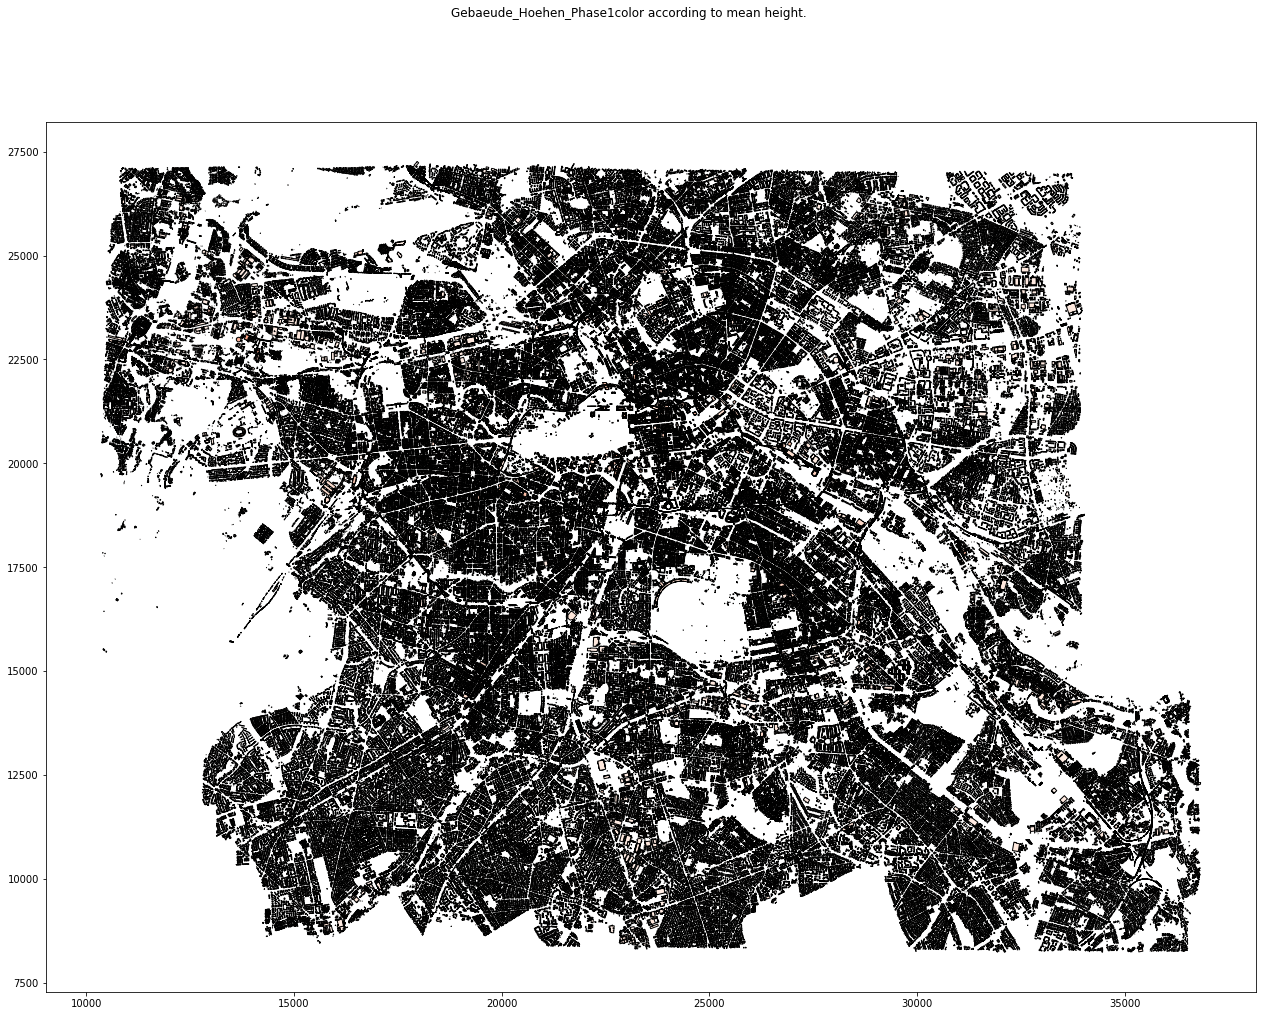

In [ ]:
# %% loop through

# Month day combinations
filenames = ["Gebaeude_Hoehen_Phase1", "Gebaeude_Hoehen_Phase2"]
dates = [[12,21], [3,21], [6,21], [9,21]]
hours = [18, 9]

for filename in filenames:
    print("open ", filename)
    connection = r'./GeoData/' + filename + '.shp'
    # Importing an ESRI Shapefile
    footprint_df = gpd.read_file(connection)
    print("file read.")
    if("Class_name" in footprint_df.columns):
        footprint_df = footprint_df[
            (footprint_df['Mean_nDOM'] > 0) & 
            (footprint_df['Class_name'] != 'Veg < 2,5 m (einschl. Rasen, Grünland)')
        ]
    
    footprint_df['height'] = footprint_df['Mean_nDOM']

    #reproject to obtain proper WGS84 latitude-longitude projection EPSG:4326, 
    # to obtain correct coordinates to retrieve altitude and azimuth
    footprint_df = footprint_df.to_crs(epsg = 4326)
    footprint_df['centroid'] = footprint_df.centroid
    footprint_df['long4326'] = footprint_df['centroid'].x
    footprint_df['lat4326'] = footprint_df['centroid'].y
    
    # reprojecting to DHDN / Soldner Berlin EPSG:3068 with transformation: 1777
    # DHDN: Deutsches Hauptdreiecksnetz
    # https://epsg.io/3068-15949
    footprint_df = footprint_df.to_crs(epsg = 3068)
    
    # plot using GeoPandas and Matplotlib
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
    footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
    fig.suptitle(filename + ': color according to mean height.')


    
    for mmdd in dates:
        for hh in hours:
            shadow_df = footprint_df
            # year, month, day, hour, minute, second, microsecond
            date = datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin'))
            altitude = solar.get_altitude(
                latitude_deg = 52.5, 
                longitude_deg = 13.4, 
                when = date
                )
            print("Date:" ,date, "altitude:", altitude)
            if(altitude > 0):
                progress = list(map(lambda x: (len(footprint_df)/100*x)//1, range(1,101)))
                startTime = lastTime =  datetime.now()
                leftOvers = footprint_df.index if not 'i' in locals() else footprint_df.index[i:]
                for i in leftOvers:
                # for i in footprint_df.index:
                    geom = footprint_df.loc[i, 'geometry']#, 
                    height = footprint_df.loc[i, 'height']#,
                    lat = footprint_df.loc[i, 'lat4326']#, 
                    long = footprint_df.loc[i, 'long4326']#
                    method = "difference"#,
                    showPlots = False
                    
                    if(type(geom) != shapely.geometry.polygon.Polygon):
                        continue
                    #
                    
                    (shadow) = projectShadow(
                        geom = geom, 
                        height = height,
                        lat = lat, 
                        long = long, 
                        date = date,
                        method = method,
                        showPlots = showPlots
                        )
                       
                    shadow_df.loc[i, "geometry"] = shadow
                    if(i in progress):
                        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
                        lastTime = datetime.now()
                #
                # save as new file
                newFileName = str(filename)+"_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
                print("save to ", newFileName)
                shadow_df.to_file(newFileName)
                
                oneShadowGeom = cascaded_union(shadow_df["geometry"])
                
                # plot using GeoPandas and Matplotlib
                fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (24,16))
                shadow_df.plot(ax=axs, color =  "#ccccccaa")
                footprint_df.plot(ax=axs, cmap = 'Reds', edgecolor = 'black', column = 'Mean_nDOM')
                fig.suptitle(filename + 'color according to mean height.')
                print('Overall time for shadow projection: ', datetime.now() - startTime)
        
# end loop
# print(np.array(perf["manual"]).mean()) # when not silent 0.81s # when silent 0.51s
# print(np.array(perf["polygonize"]).mean()) # when not silent 0.57 # when silent 0.15s
# print(np.array(perf["difference"]).mean()) # when not silent 0. # when silent 0.11s



In [ ]:
i

0

### Merge shadow map into single multipolygon
This can reduce memory space and make operations faster where you check wheter point is within shadow or not

In [ ]:
# %% merge and simplify polygons 

for i in footprint_df.index:
    if(i in progress):
        print(progress.index(i), "%. Time: ",  datetime.now() - lastTime)
        lastTime = datetime.now()
#
                #
                
a = list(map(lambda x: type(x), shadow_df['geometry']))
from itertools import groupby
[len(list(group)) for key, group in groupby(a)]

from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
df = gpd.GeoSeries([geom])
df.crs = "EPSG:3068"
df = df.to_crs(4326)
poly = geom#Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('./out/'+newFileName+'ONE'+'.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(oneShadowGeom),
        'properties': {'id': newFileName},
    })

# Intersecting Layers intersection = gpd.overlay(layer1, layer2, how = 'intersection')
# Union Layers union = gpd.overlay(layer1, layer2, how = 'union')
# how = [
#   'symmetric_difference'= A|B & !A&B, 
#   'difference' = A & !B, 
#   'dissolve' = merge, 
#       first give union common variable with same value union['common_column'] = 1
#       disolve: union_desolved = union.dissolve(by='commun_column')

# shapely:: object.simplify(tolerance, preserve_topology=True) Returns a simplified representation of the geometric object.

# https://geopandas.org/docs/user_guide/geometric_manipulations.html
# https://geopandas.org/docs/user_guide/data_structures.html
# districts_in_aoi['area'] = districts_in_aoi.area/1000000

# Exporting GeoPandas GeoDataFrames into an ESRI Shapefile
# districts_in_aoi.to_file('districts_within_aoi.shp', driver = "ESRI Shapefile")

# Create figures for illustration of method on how shadows are computed

### Shadow of a pole for each date time combination

Date: 2021-06-21 18:00:00+00:53 altitude: 18.623893099082913
Date: 2021-06-21 09:00:00+00:53 altitude: 45.12588180906564


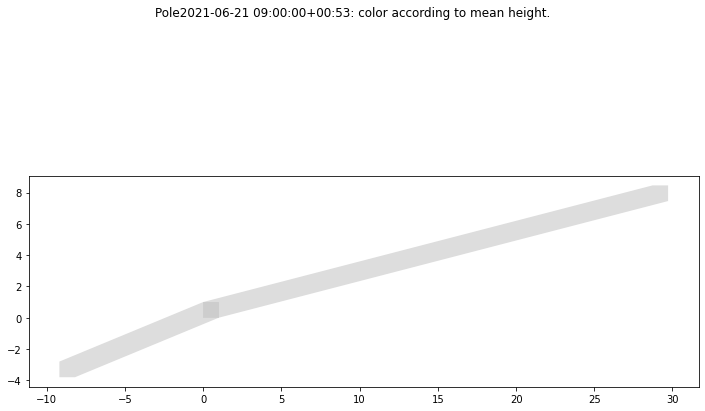

In [ ]:
# 2Do create a figure that shows the shadow of a pole for all times of the day for each date

# Month day combinations
dates = [[12,21], [3,21], [6,21], [9,21]]
hours = [18, 9]

dates = [[6,21]]
hours = [18,9]

ber_lat = 52.5
ber_lon = 13.4

for mmdd in dates:
    shadow_df = gpd.GeoDataFrame(geometry=[Polygon([(ber_lon,ber_lat),(ber_lon+0.001,ber_lat),(ber_lon+0.001,ber_lat+0.001),(ber_lon,ber_lat+0.001)])])
    shadow_df = gpd.GeoDataFrame(geometry=[Polygon([(0,0),(1,0),(1,1),(0,1)])])
    for hh in hours:
        # year, month, day, hour, minute, second, microsecond
        date = datetime(2021, *mmdd, hh, 0, 0, 0, tzinfo=pytz.timezone('Europe/Berlin'))
        altitude = solar.get_altitude(
            latitude_deg = ber_lat, 
            longitude_deg = ber_lon, 
            when = date
            )
        print("Date:" ,date, "altitude:", altitude)
        if(altitude > 0):
            geom = shadow_df.iloc[0]["geometry"]#, 
            height = 10#,
            lat = ber_lat#, 
            long = ber_lon#
            method = "difference"#,
            showPlots = False
            
            if(type(geom) != shapely.geometry.polygon.Polygon):
                continue
            #
            
            (shadow) = projectShadow(
                geom = geom, 
                height = height,
                lat = lat, 
                long = long, 
                date = date,
                method = method,
                showPlots = showPlots
                )
                
            shadow_df = shadow_df.append( gpd.GeoDataFrame(geometry=[shadow]) )
            # save as new file
            #newFileName = "pole_"+str(mmdd[0])+"-"+str(mmdd[1])+"_"+str(hh)+".shp"
            #print("save to ", newFileName)
            #shadow_df.to_file(newFileName)
            
    oneShadowGeom = cascaded_union(shadow_df["geometry"])
        
    # plot using GeoPandas and Matplotlib
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
    shadow_df.plot(ax=axs, color =  "#ccccccaa")
    fig.suptitle("Pole" + str(date) + ': color according to mean height.')
        



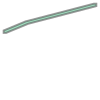

In [ ]:
shadow_df

,geometry
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
0,"POLYGON ((0.00001 -0.00000, 0.00001 -0.00000, ..."
0,"POLYGON ((-8.19910 -3.80809, -8.19910 -3.80809..."


In [ ]:
shadow_df = gpd.GeoDataFrame(geometry=[Polygon([(0,0),(1,0),(1,1),(0,1)])])
shadow_df

,geometry
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."


In [ ]:
newrow = shadow_df.loc[0]
newrow["geometry"] = Polygon([(0,0),(1,0),(1,1),(0,1)])
shadow_df=shadow_df.append(newrow)

KeyError: 0

In [ ]:
shadow_df

,geometry
0,"POLYGON ((-73.04569 -88.02911, -73.04569 -88.0..."
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."


# speed up code by 
- evaluate wheter set() makes it faster
- don't call fcts from objects like math.fun()
- Use multiple assignments like a, b, c, d = 2, 3, 5, 7
- L = [i for i in range (1, 1000) if i%3 == 0]
- Use proper data structure whereever possible